# Wavelet analysis and forged banknotes: unsupervised machine learning - dimension reduction and clustering

The objectives of the exercise:

**A.** Produce alternative versions of the dataset by means of different data dimensionality reduction methods (manual and UML).

**B.** Train clustering models to predict if a banknote is genuine or not based on the dataset from OpenML containing wavelet analysis results for genuine and forged banknotes. This is just an exercise in application of UML algorithms. SML models are actually far better for this task (https://github.com/BeataWereszczynska/SML_forged_banknotes).


## 1. The data

### 1.1. Description & exploration

The dataset originates from OpenML and contains wavelet analysis results for genuine and forged banknotes. The authors describe it as follows: 

*Dataset about distinguishing genuine and forged banknotes. Data were extracted from images that were taken from genuine and forged banknote-like specimens. For digitization, an industrial camera usually used for print inspection was used. The final images have 400x 400 pixels. Due to the object lens and distance to the investigated object gray-scale pictures with a resolution of about 660 dpi were gained. A Wavelet Transform tool was used to extract features from these images* [https://www.openml.org/search?type=data&sort=runs&id=1462&status=active]. 

Data reference: Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

The data table contains 4 columns with parameters from wavelet analysis (V1 – variance of Wavelet Transformed image, V2 – skewness of Wavelet Transformed image, V3 – curtosis of Wavelet Transformed image, V4 – entropy of image) and Class column describing if the banknote is genuine (1) or forged (2). There are 762 rows for genuine banknotes and 610 rows for forged ones.

The Class column was excluded from the data used for training models and served as ground truth in the validation phase.

In [1]:
# Data import
import pandas as pd
data = pd.read_csv('Banknote-authentication-dataset.csv')
data

V1        V2       V3       V4  Class
0     3.62160   8.66610  -2.8073 -0.44699      1
1     4.54590   8.16740  -2.4586 -1.46210      1
2     3.86600  -2.63830   1.9242  0.10645      1
3     3.45660   9.52280  -4.0112 -3.59440      1
4     0.32924  -4.45520   4.5718 -0.98880      1
...       ...       ...      ...      ...    ...
1367  0.40614   1.34920  -1.4501 -0.55949      2
1368 -1.38870  -4.87730   6.4774  0.34179      2
1369 -3.75030 -13.45860  17.5932 -2.77710      2
1370 -3.56370  -8.38270  12.3930 -1.28230      2
1371 -2.54190  -0.65804   2.6842  1.19520      2

[1372 rows x 5 columns]

In [2]:
# Genuine and forged count
data.Class.value_counts()

1    762
2    610
Name: Class, dtype: int64

In [3]:
# Summary statistics
data.describe()

V1           V2           V3           V4        Class
count  1372.000000  1372.000000  1372.000000  1372.000000  1372.000000
mean      0.433735     1.922353     1.397627    -1.191657     1.444606
std       2.842763     5.869047     4.310030     2.101013     0.497103
min      -7.042100   -13.773100    -5.286100    -8.548200     1.000000
25%      -1.773000    -1.708200    -1.574975    -2.413450     1.000000
50%       0.496180     2.319650     0.616630    -0.586650     1.000000
75%       2.821475     6.814625     3.179250     0.394810     2.000000
max       6.824800    12.951600    17.927400     2.449500     2.000000

In [4]:
data.isnull().any()

V1       False
V2       False
V3       False
V4       False
Class    False
dtype: bool

<AxesSubplot:>

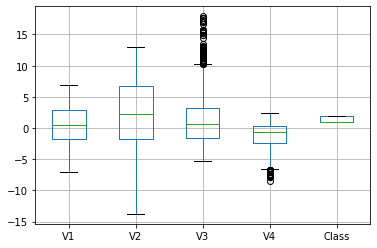

In [5]:
# Boxplot for outliers inspection
data.boxplot()

The data is good quality - there are no gaps or Not-a-Numbers and the calculated summary statistics look reasonable. There are no actual outliers (single data points far away from the rest of the dataset), but V3 and V4 data have some "tails".

The plots below shows genuine (green) and forged (red) banknotes data.

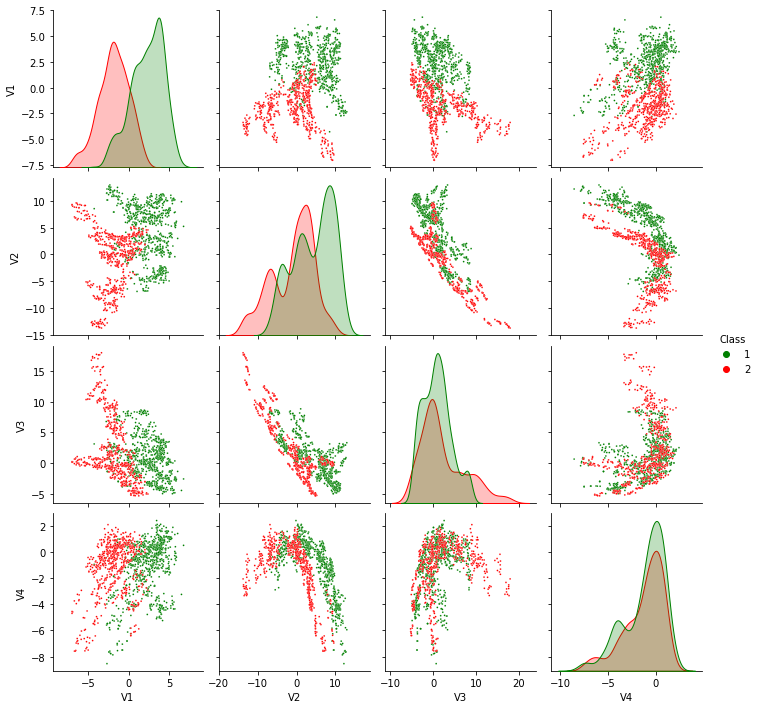

In [6]:
# visual check of the correlations between the variables - pairplot
import seaborn as sns
sns.pairplot(data, hue='Class', palette={1:'green',2:'red'}, plot_kws={"s": 3})


Classes are not easily separable in any of 2D plots. V2, V3 and V4 seem to be non-linearly correlated with each other, so it may be beneficial to get rid of one of them and stay with just three variables. The datapoints for different classes are least separable in V3-V4 plots, so there is no reason to use these variables together. Distribution of genuine and forged banknotes data overlaps the most on the V4 plot. To summarize, it can be deduced from the above, that V4 could be dropped if manual dimensionality reduction was performed.

Lets inspect 3D plots with different sets of variables for reasurance.

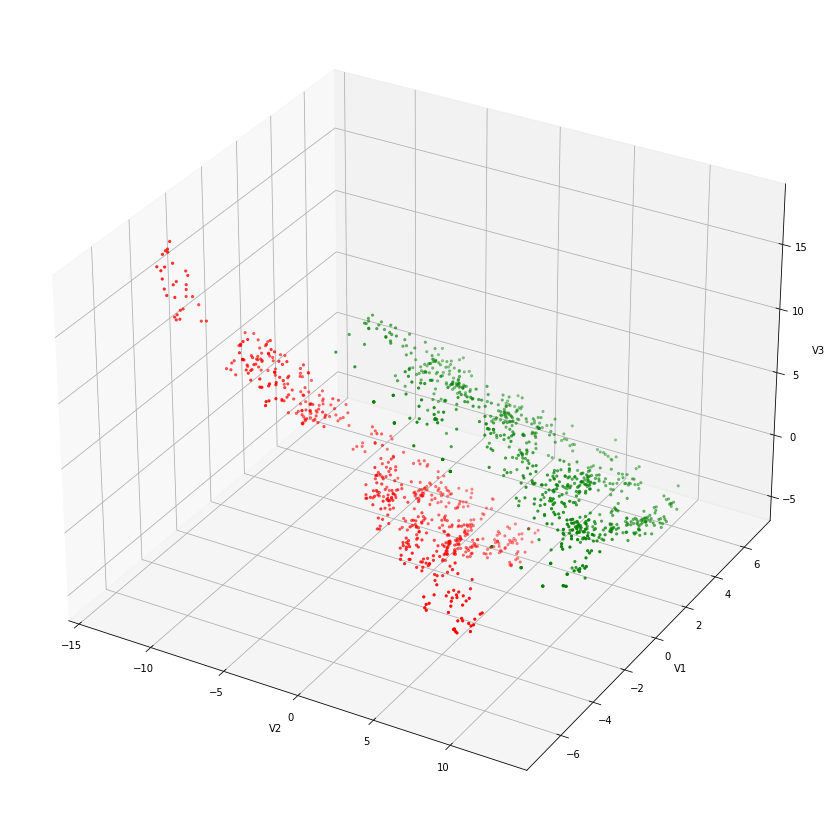

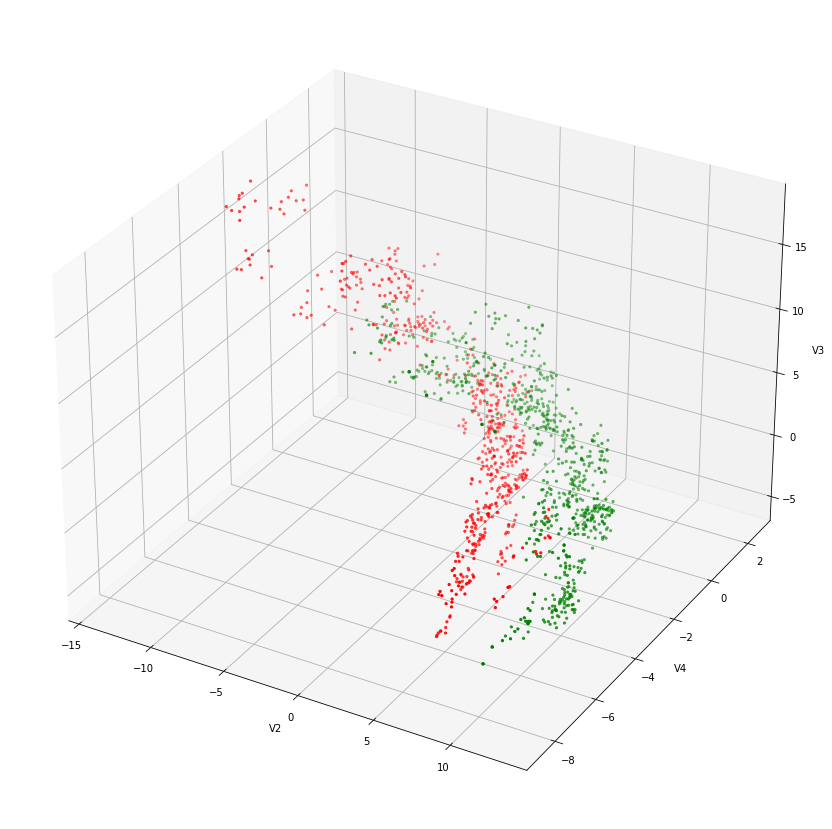

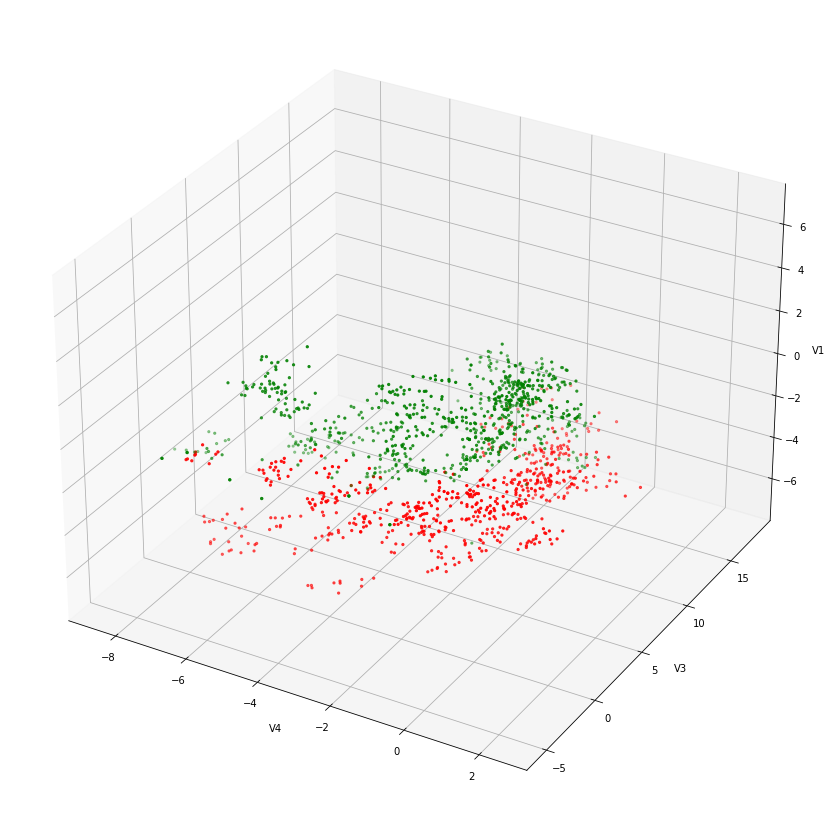

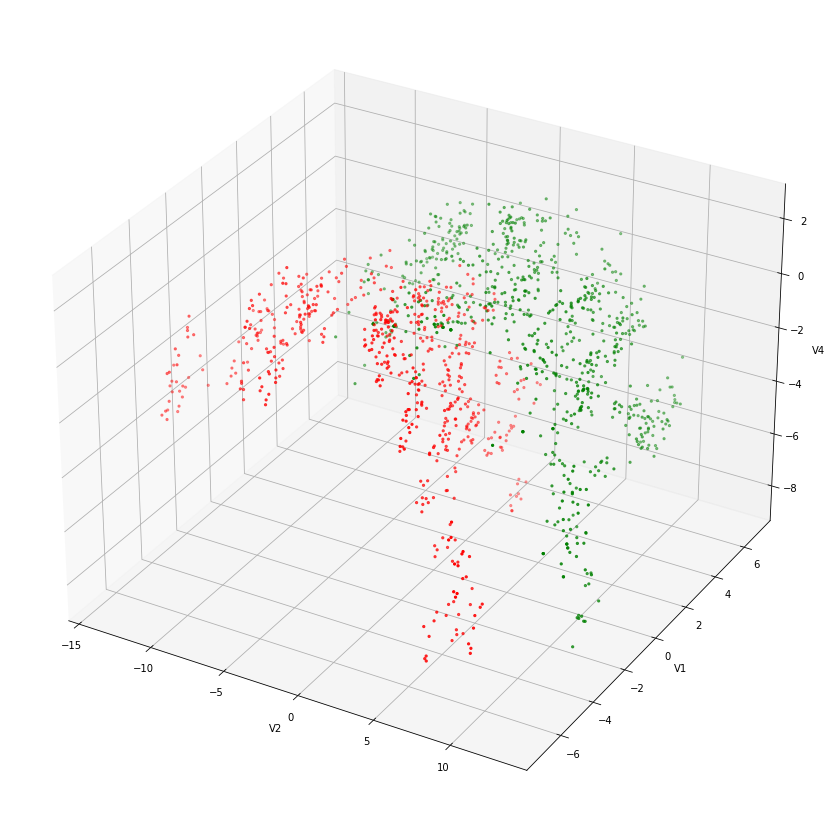

In [7]:
# 3D plots

import matplotlib.pyplot as plt

V_sets = [('V2', 'V1', 'V3'), ('V2', 'V4', 'V3'), ('V4', 'V3', 'V1'), ('V2', 'V1', 'V4')]

for (a,b,c) in V_sets:
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(data[data['Class'] == 1][a], data[data['Class'] == 1][b], data[data['Class'] == 1][c],
              s=5, color='green')
    ax.scatter(data[data['Class'] == 2][a], data[data['Class'] == 2][b], data[data['Class'] == 2][c],
              s=5, color='red')
    plt.xlabel(a)
    plt.ylabel(b)
    ax.set_zlabel(c)
    plt.show()

The set of V1, V2 and V3 parameters still seems to be the most prommissing.

### 1.2. Data preparation

The data was normalized to the range between 0 and 1 and the Class column was separated from the data (see below).

In [8]:
# Normalization (0 - 1)
col_names = data.columns
from sklearn import preprocessing
data = pd.DataFrame(preprocessing.minmax_scale(data, feature_range=(0, 1), axis=0, copy=True))
data.columns = col_names
data.Class = data.Class.astype(int)

# Separating the Class column from the rest of the data
y_test = pd.DataFrame(data['Class'])
data.drop(['Class'], axis=1, inplace=True)
data

# Inspecting the variables data
data

V1        V2        V3        V4
0     0.769004  0.839643  0.106783  0.736628
1     0.835659  0.820982  0.121804  0.644326
2     0.786629  0.416648  0.310608  0.786951
3     0.757105  0.871699  0.054921  0.450440
4     0.531578  0.348662  0.424662  0.687362
...        ...       ...       ...       ...
1367  0.537124  0.565855  0.165249  0.726398
1368  0.407690  0.332868  0.506753  0.808350
1369  0.237385  0.011768  0.985603  0.524755
1370  0.250842  0.201701  0.761587  0.660675
1371  0.324528  0.490747  0.343348  0.885949

[1372 rows x 4 columns]

In [9]:
# inspecting the class data
y_test

Class
0         0
1         0
2         0
3         0
4         0
...     ...
1367      1
1368      1
1369      1
1370      1
1371      1

[1372 rows x 1 columns]

### 1.3. Dimensionality reduction

There are different ways to reduce data dimencionality. Here we will compare results for manual removing variable V4 and unsupervised ML methods. The correlations between the variables are nonlinear, so kernel Principal Component Analysis (kPCA) and  T-Distributed Stochastic Neighbor Embedding (TSNE) will be used for UML based dimensionality reduction.

#### 1.3.1. Manual variable picking

In [10]:
data_MAN = data.drop(['V4'], axis=1)
data_MAN

V1        V2        V3
0     0.769004  0.839643  0.106783
1     0.835659  0.820982  0.121804
2     0.786629  0.416648  0.310608
3     0.757105  0.871699  0.054921
4     0.531578  0.348662  0.424662
...        ...       ...       ...
1367  0.537124  0.565855  0.165249
1368  0.407690  0.332868  0.506753
1369  0.237385  0.011768  0.985603
1370  0.250842  0.201701  0.761587
1371  0.324528  0.490747  0.343348

[1372 rows x 3 columns]

#### 1.3.2. Unsupervised ML methods: Kernel PCA
Attempts were made to describe the data with 2 or 3 principal components.

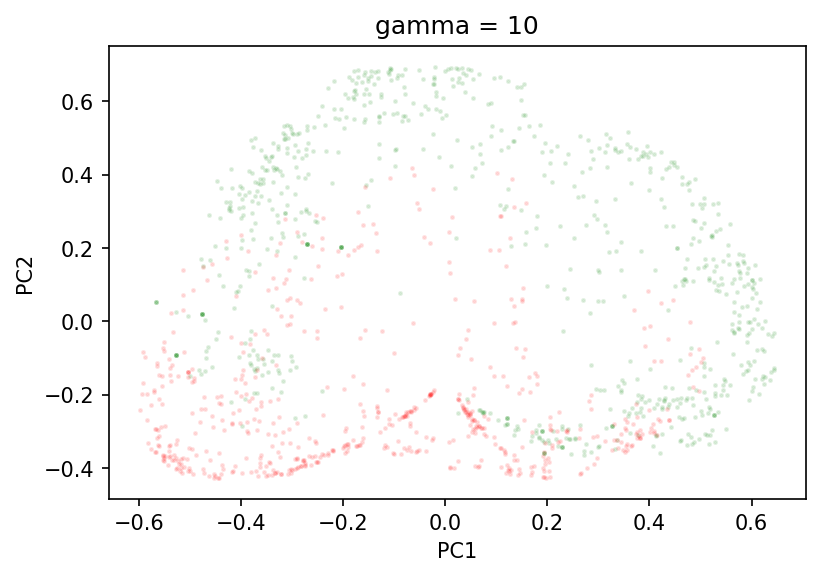

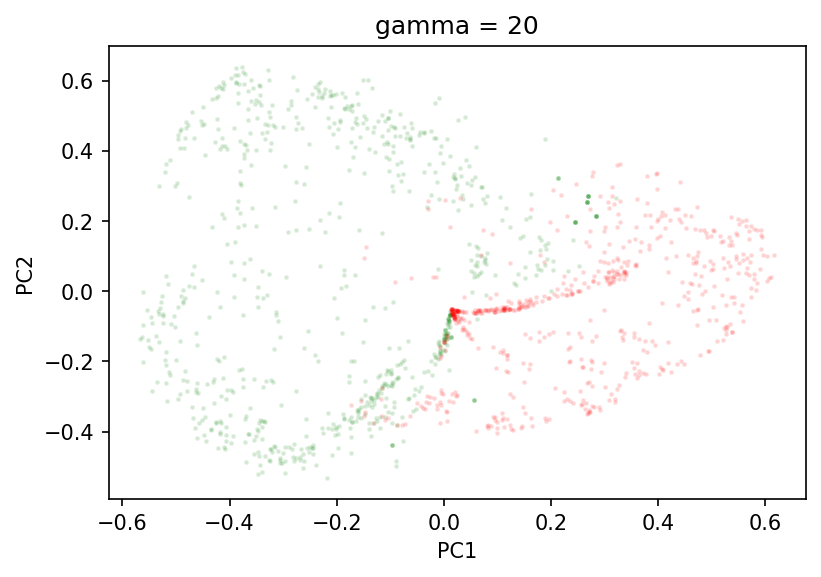

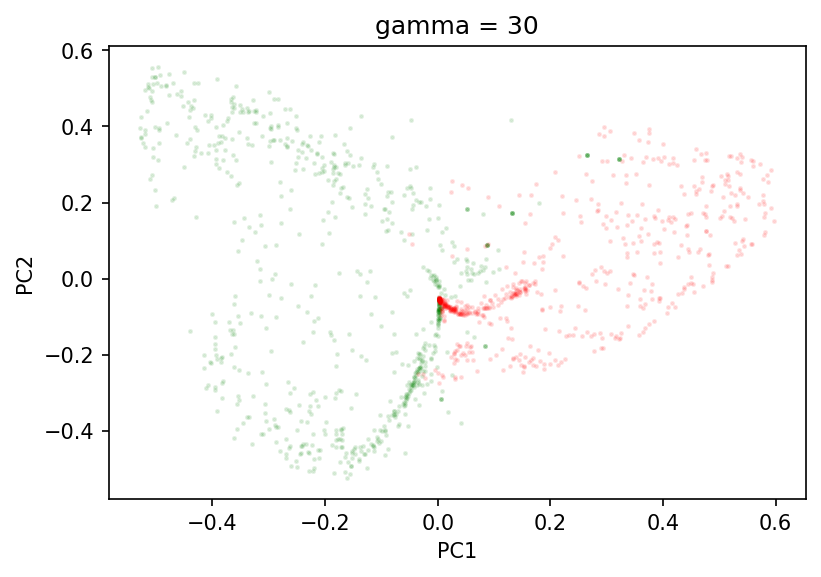

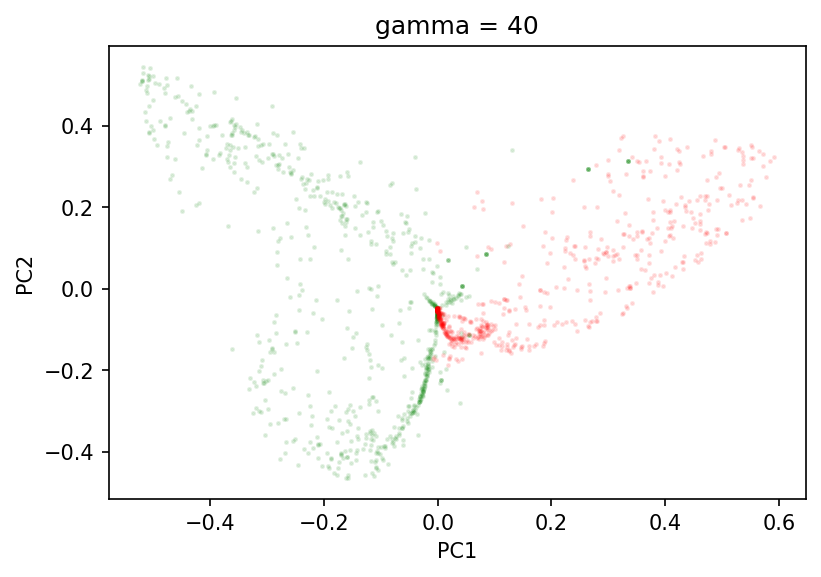

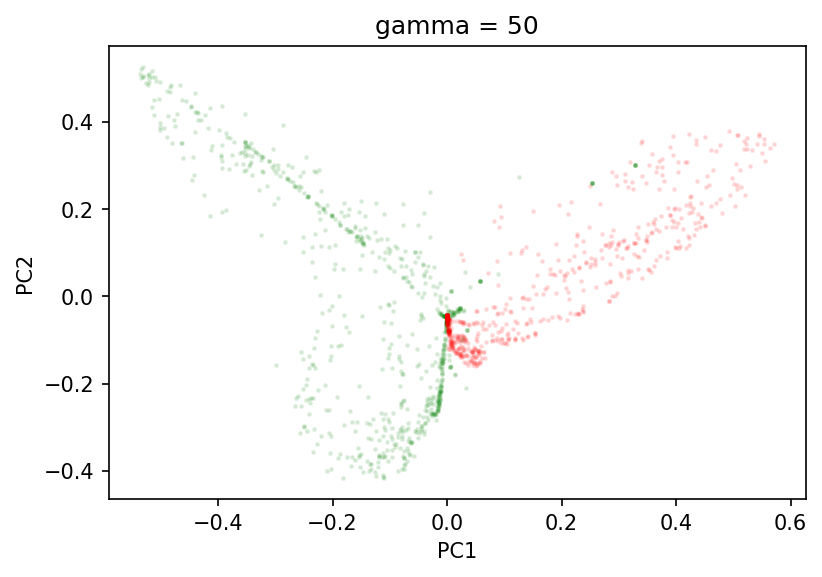

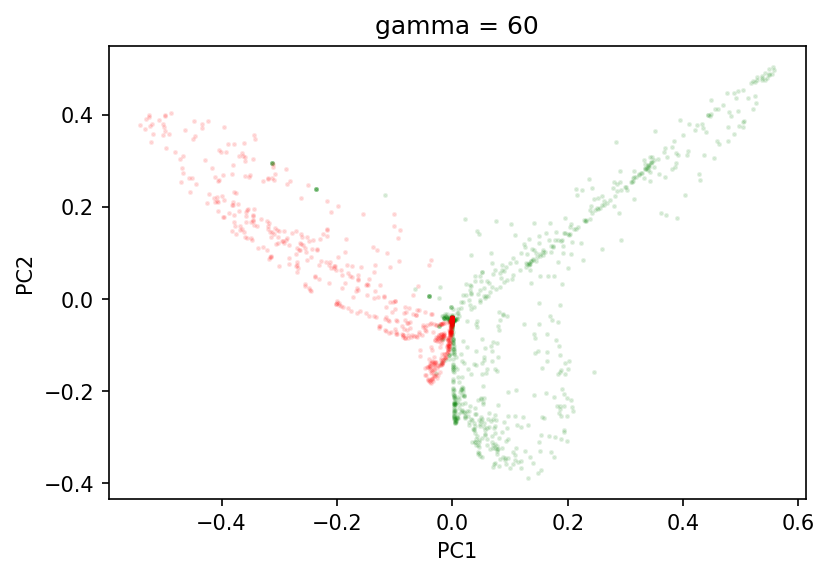

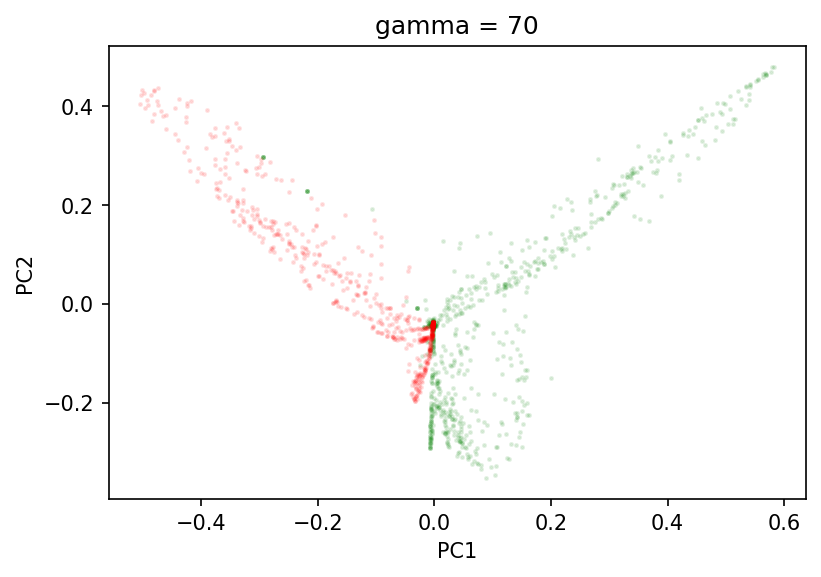

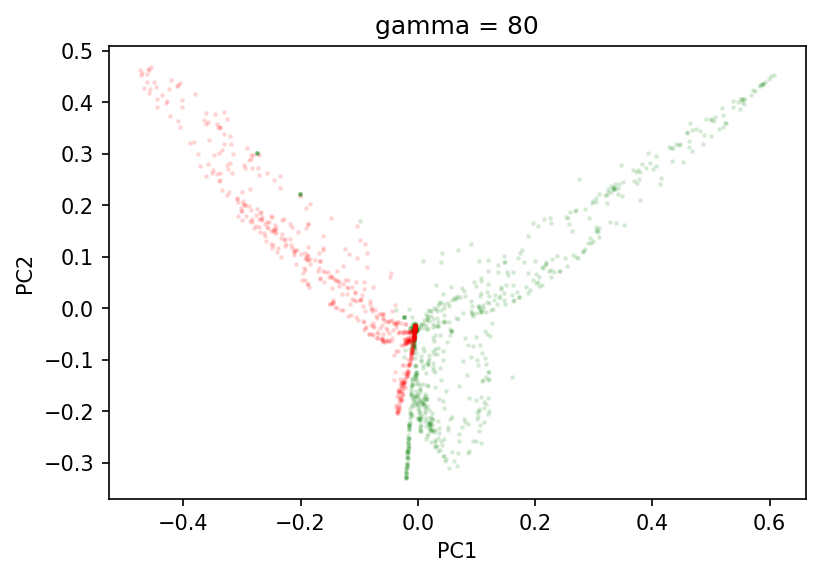

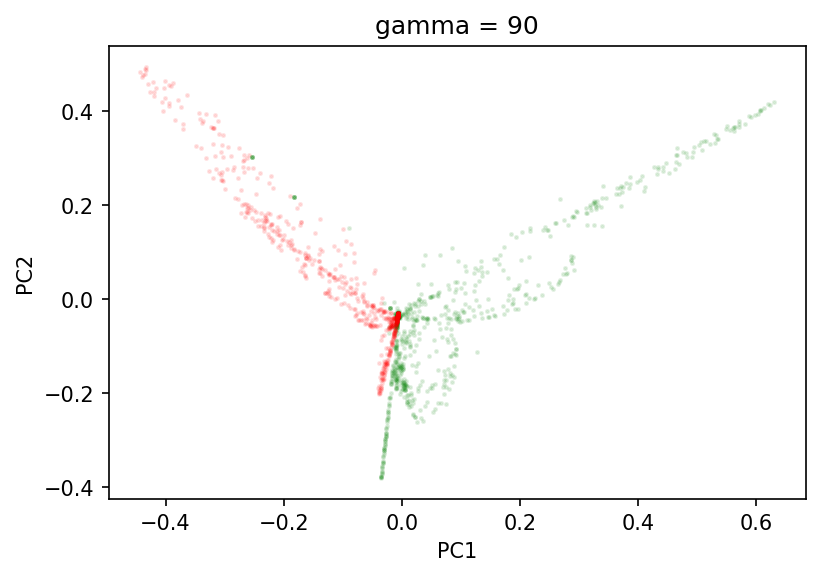

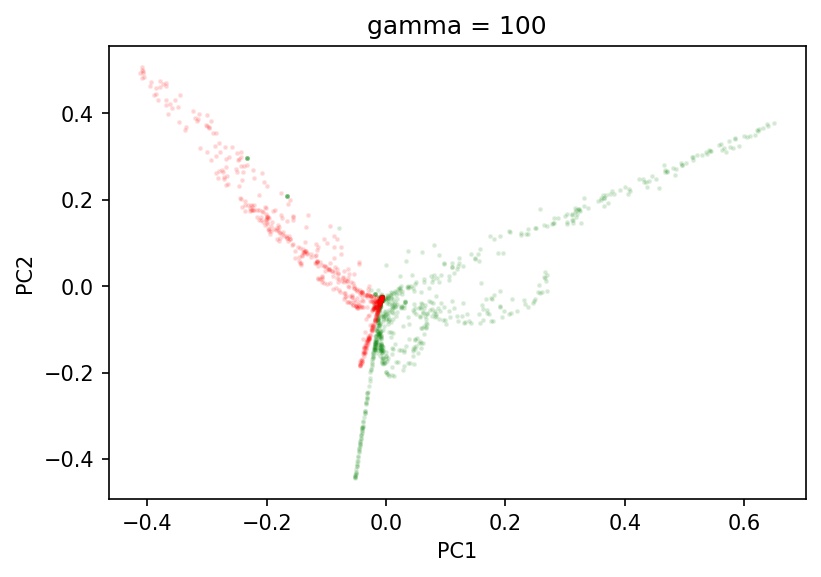

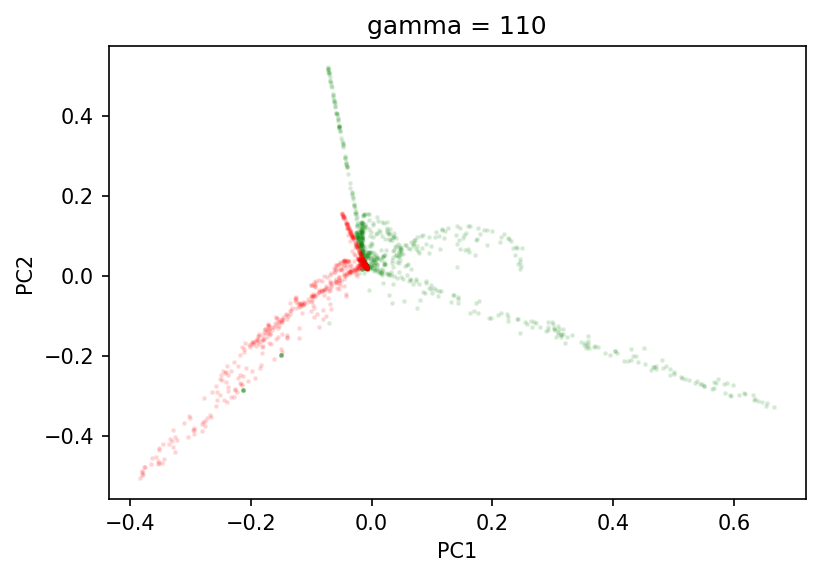

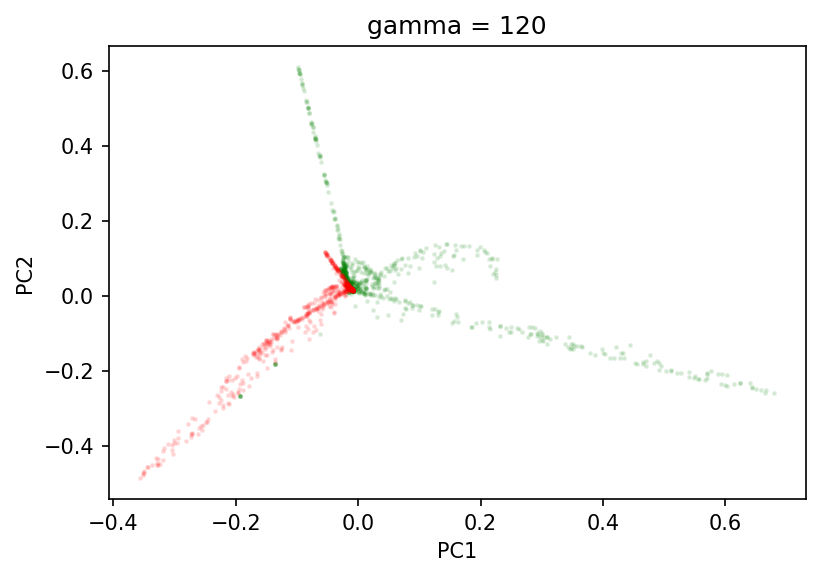

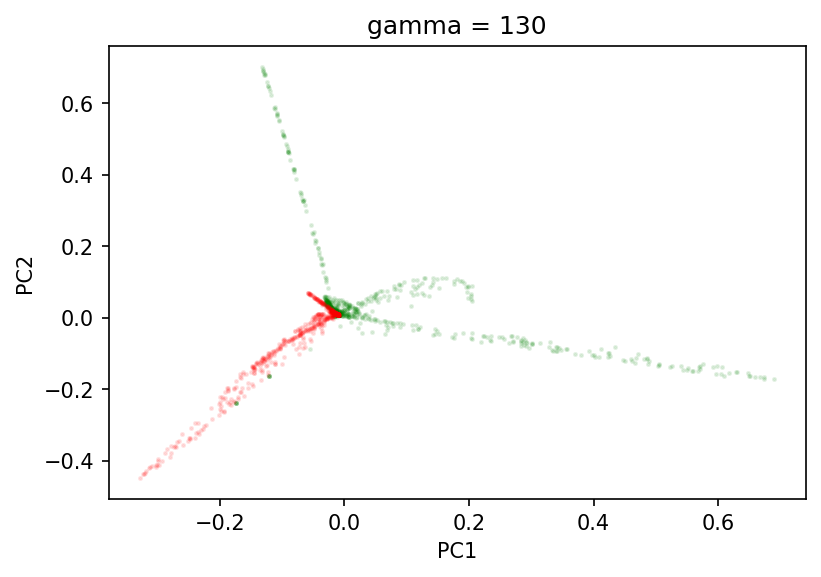

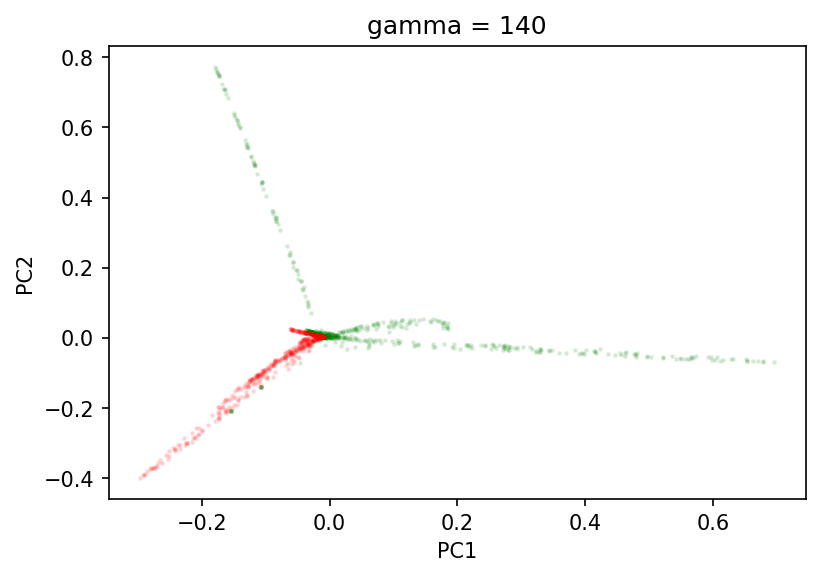

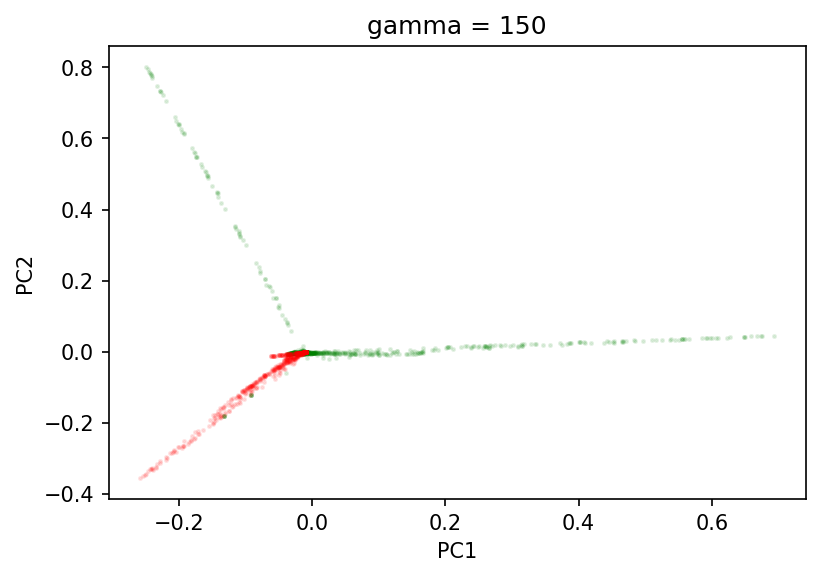

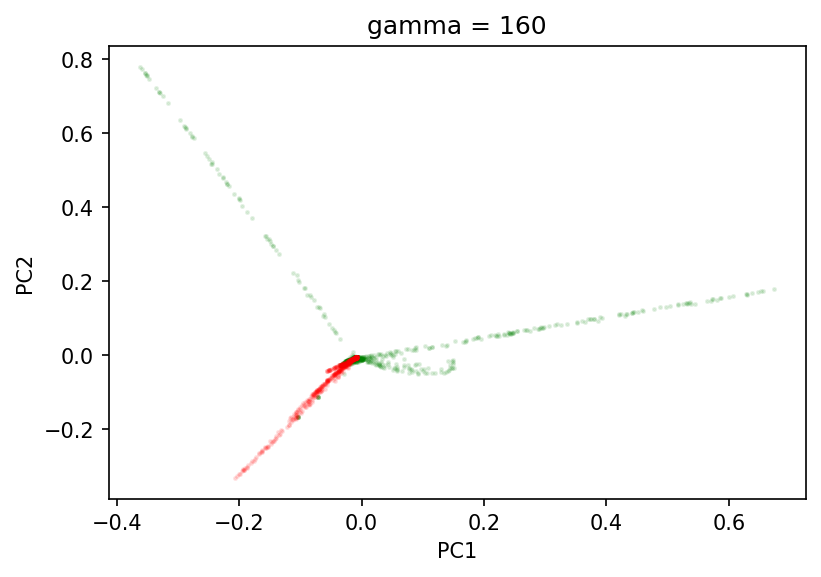

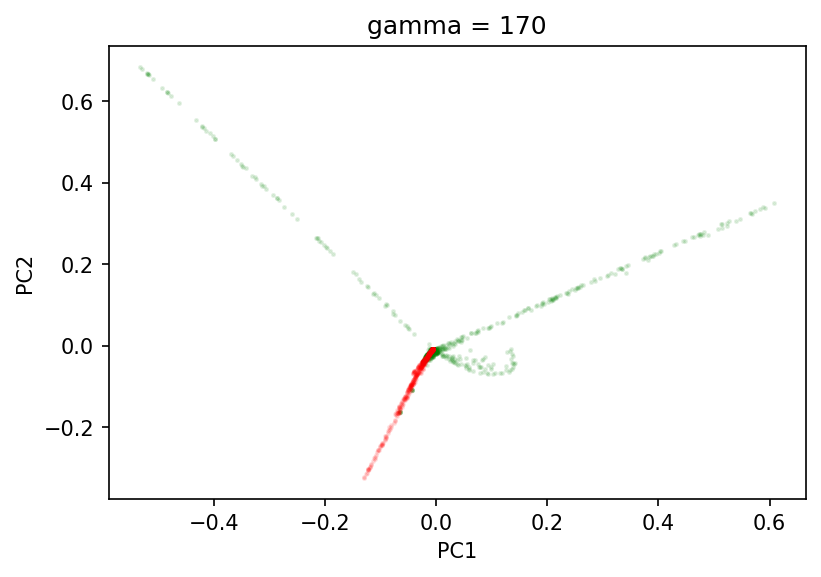

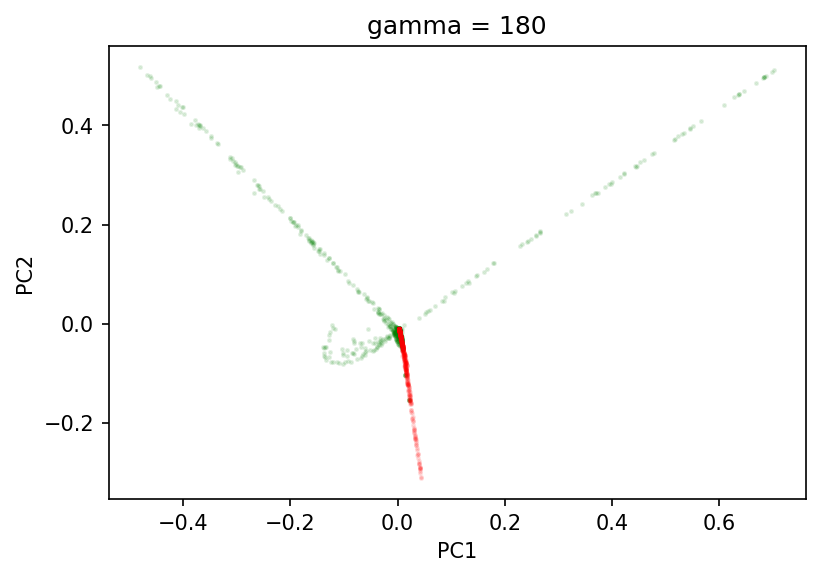

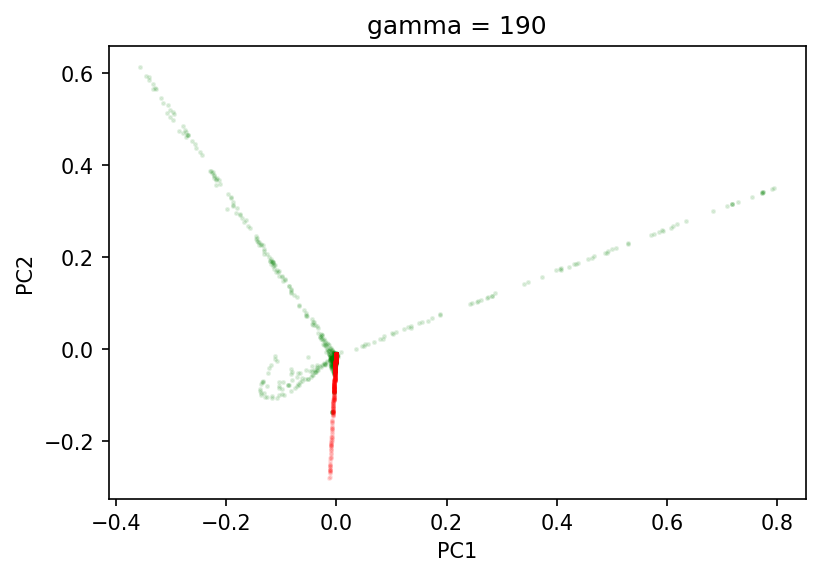

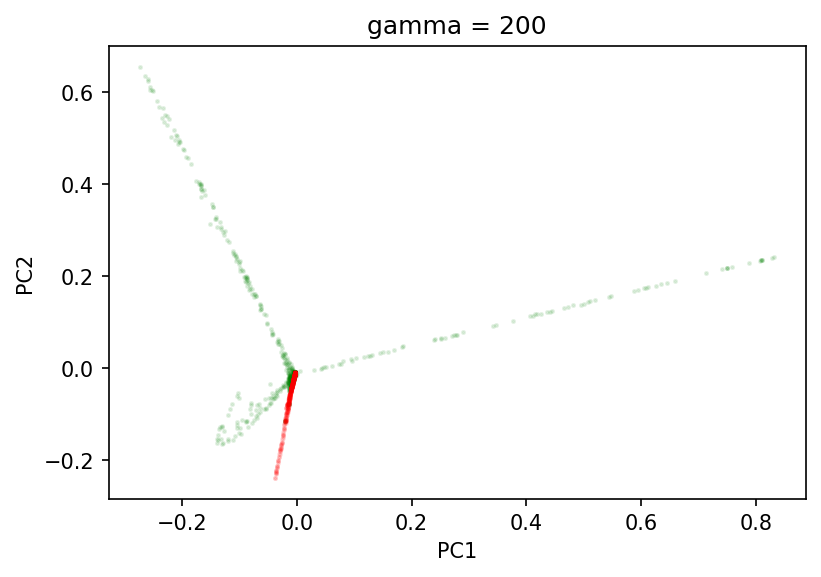

In [11]:
from sklearn.decomposition import KernelPCA

gammas=range(10,201,10)

for gamma in gammas:
    # Kernel PCA: 2 components
    kernel_PCA2 = KernelPCA(kernel="rbf", gamma=gamma, n_components=2)
    data_kPCA2 = pd.DataFrame(kernel_PCA2.fit_transform(data))

    # 2D plot of genuine and forged
    plt.figure(dpi=150)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.scatter(data_kPCA2[y_test['Class'] == 0][0], data_kPCA2[y_test['Class'] == 0][1], s=2, color='green', alpha=0.1)
    plt.scatter(data_kPCA2[y_test['Class'] == 1][0], data_kPCA2[y_test['Class'] == 1][1], s=2, color='red', alpha=0.1)
    plt.title(f'gamma = {gamma}')
    plt.show()
    
del kernel_PCA2, data_kPCA2

Two principal components seem to be not enough.

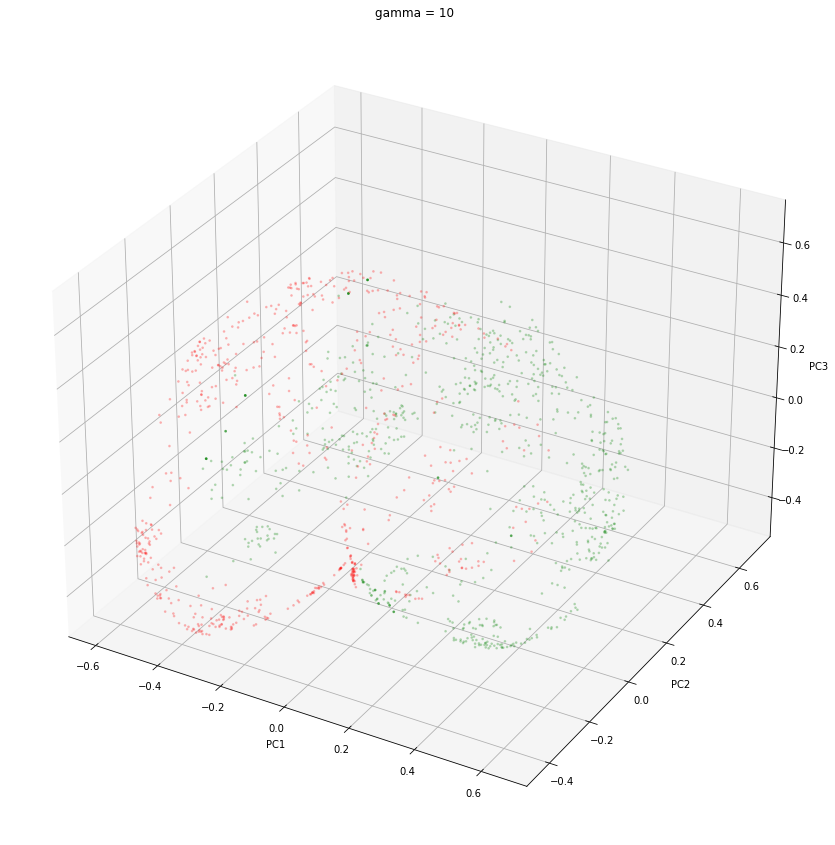

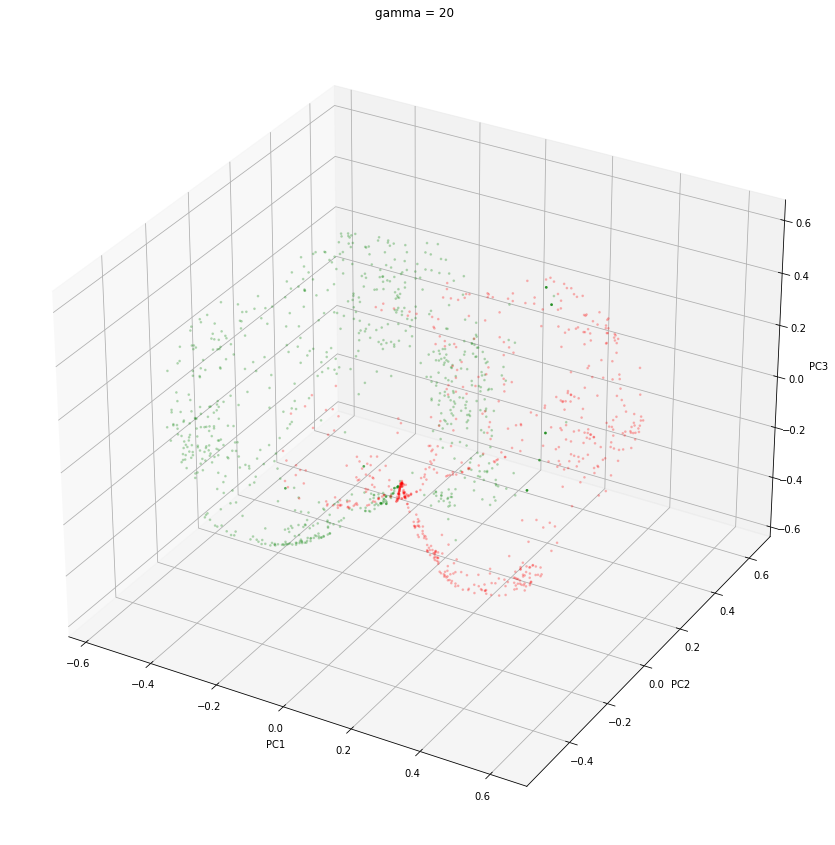

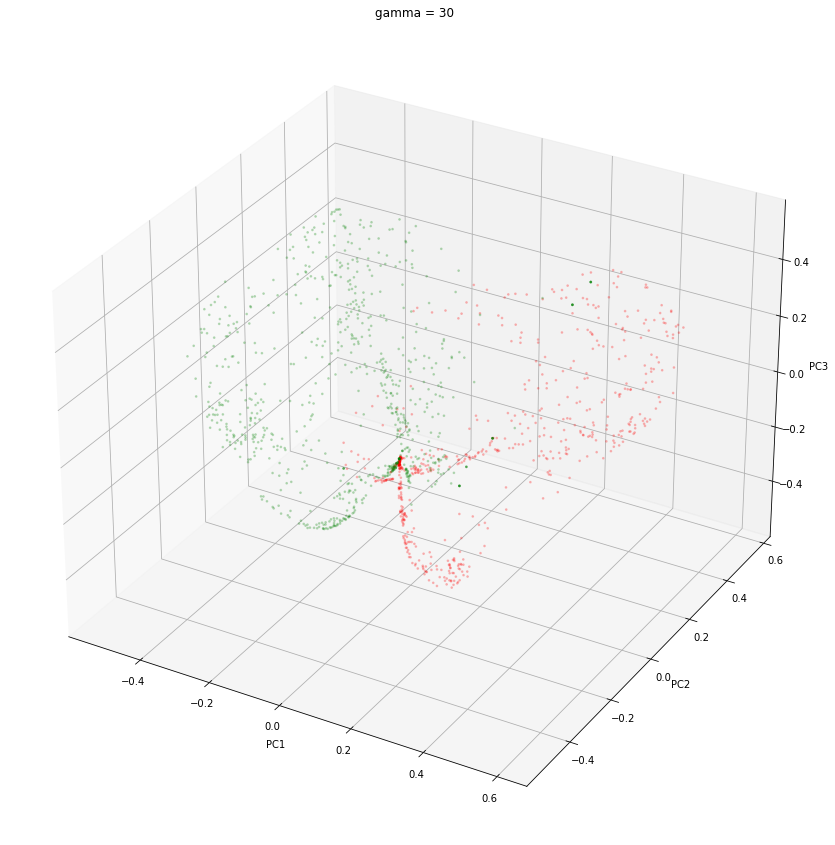

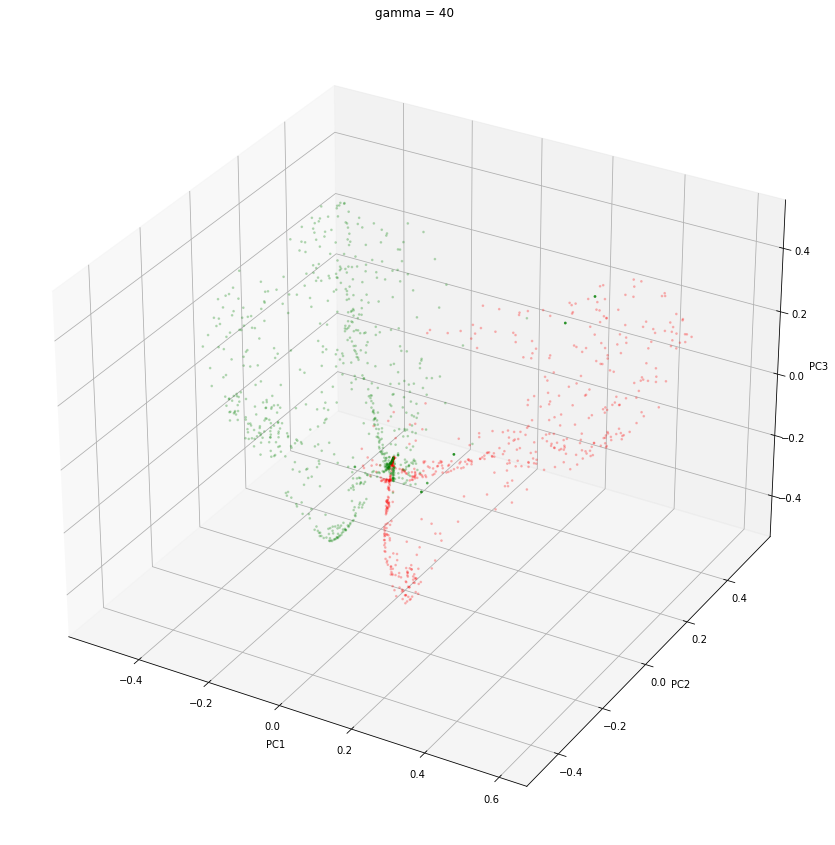

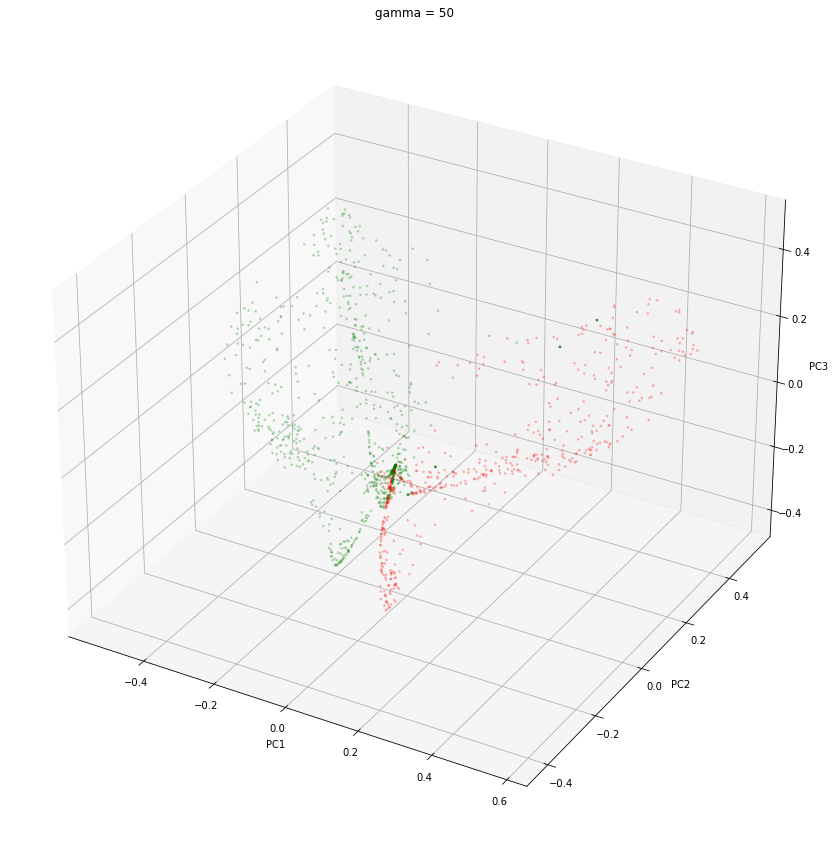

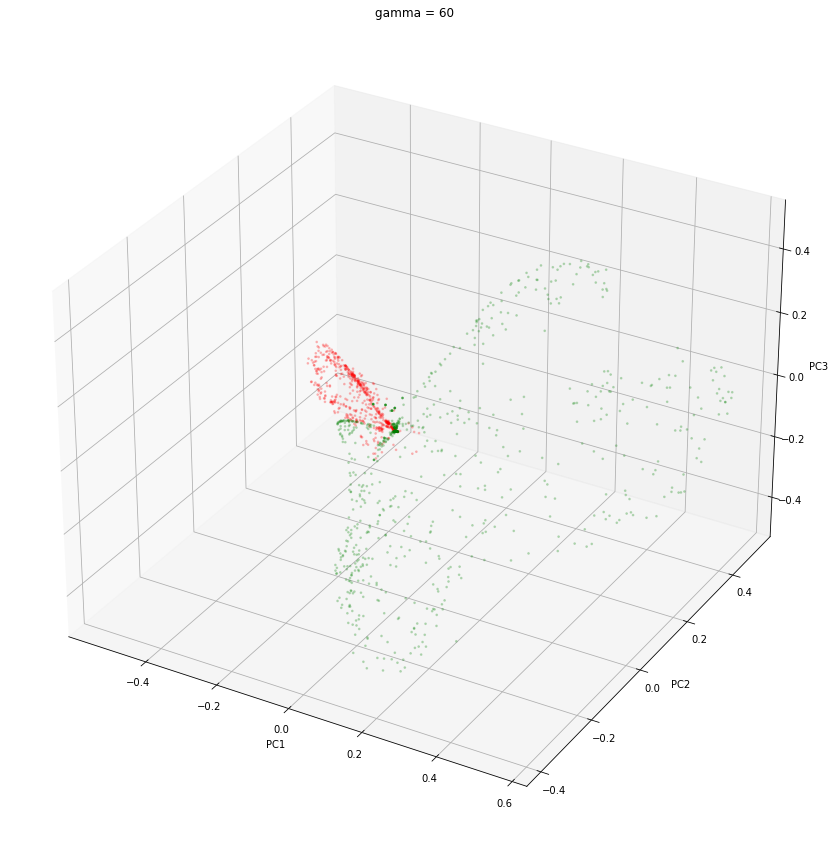

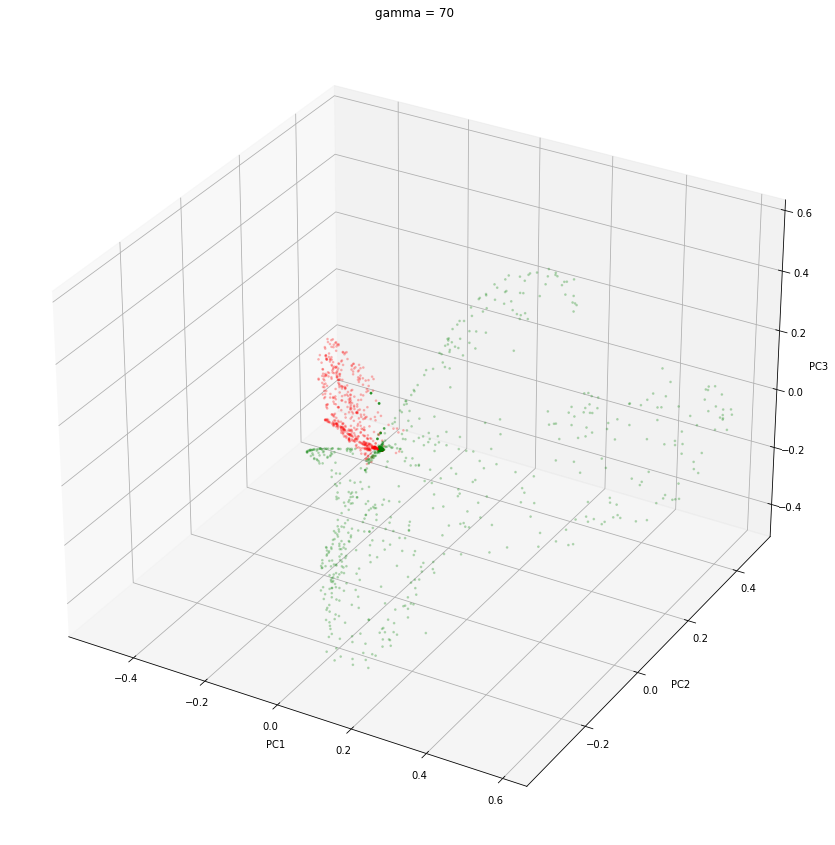

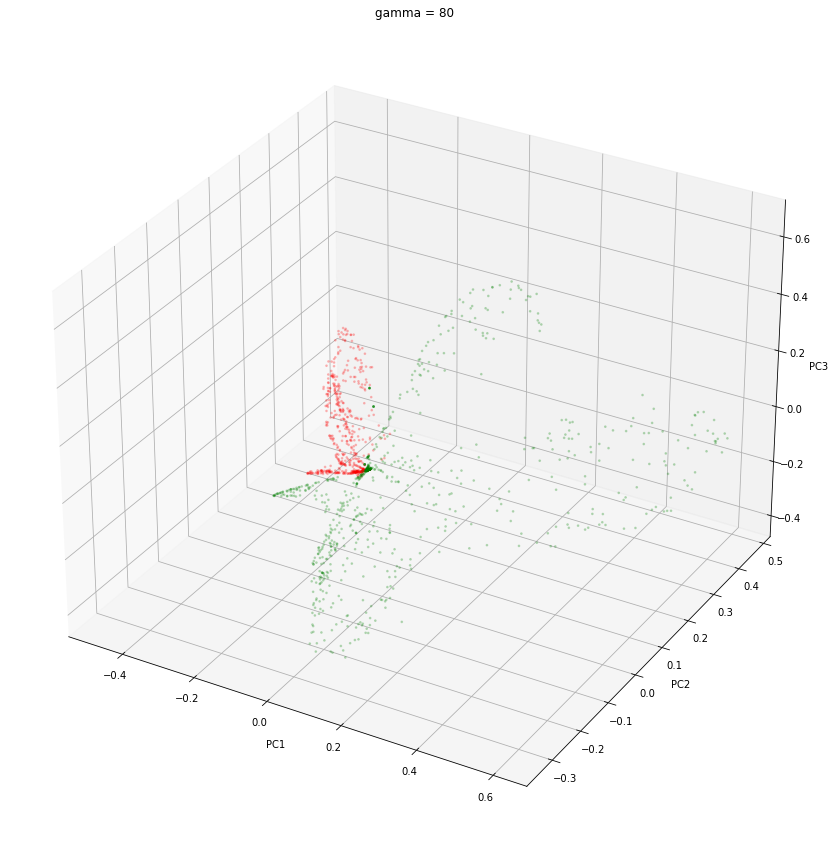

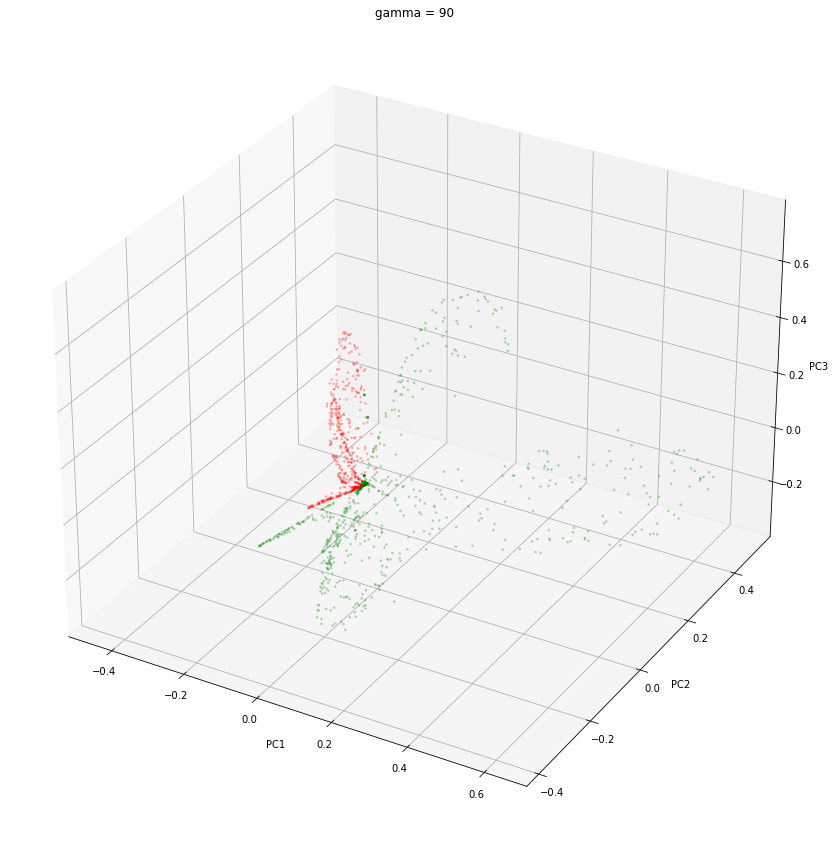

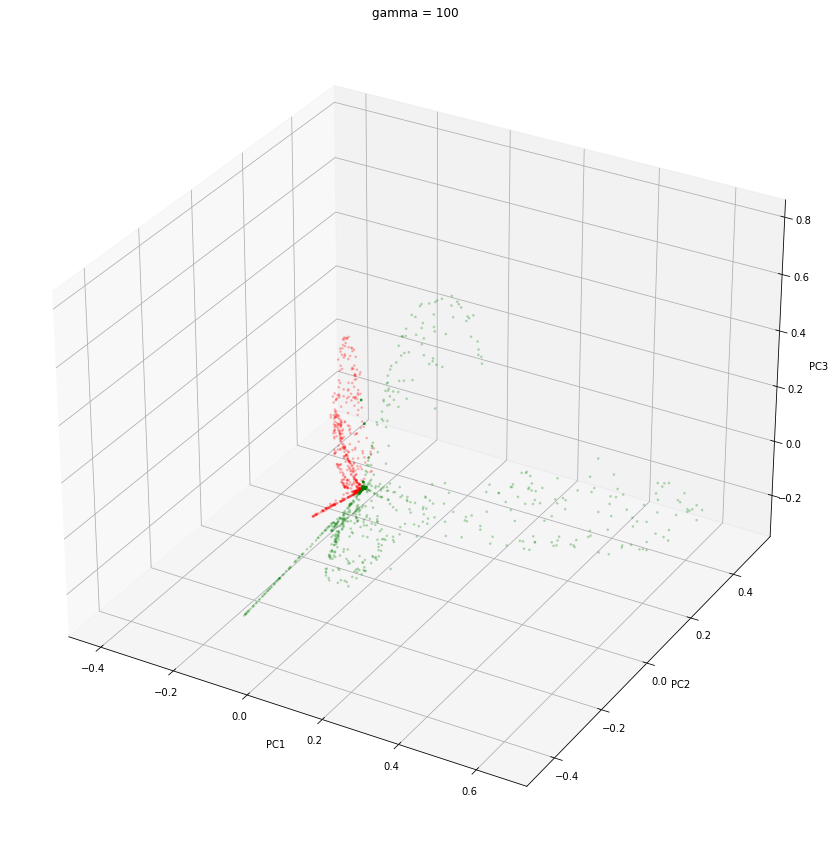

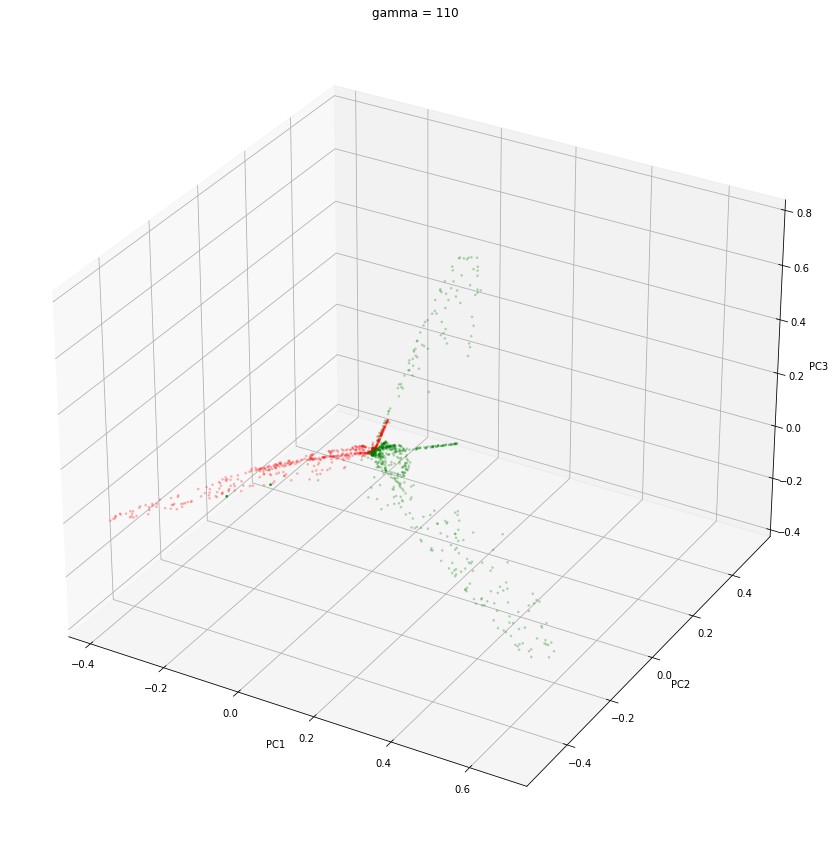

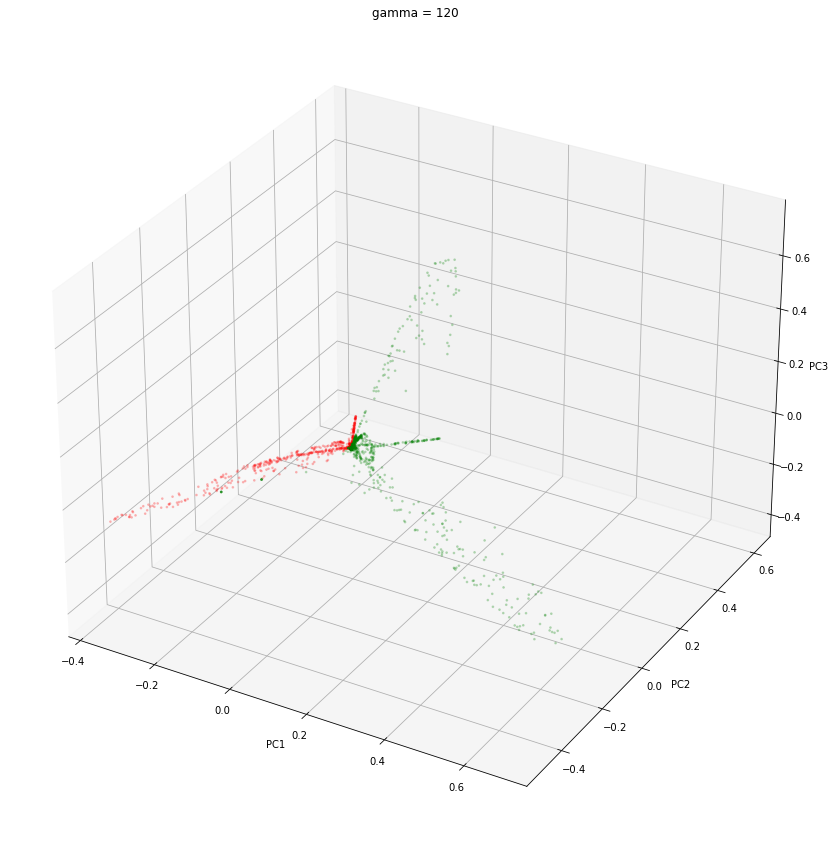

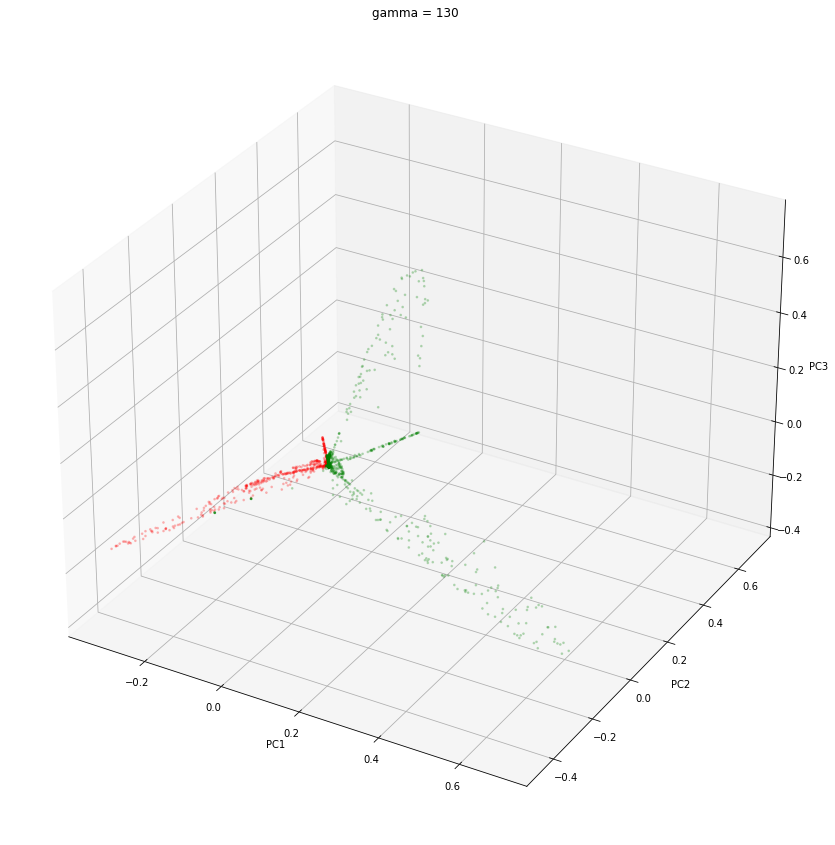

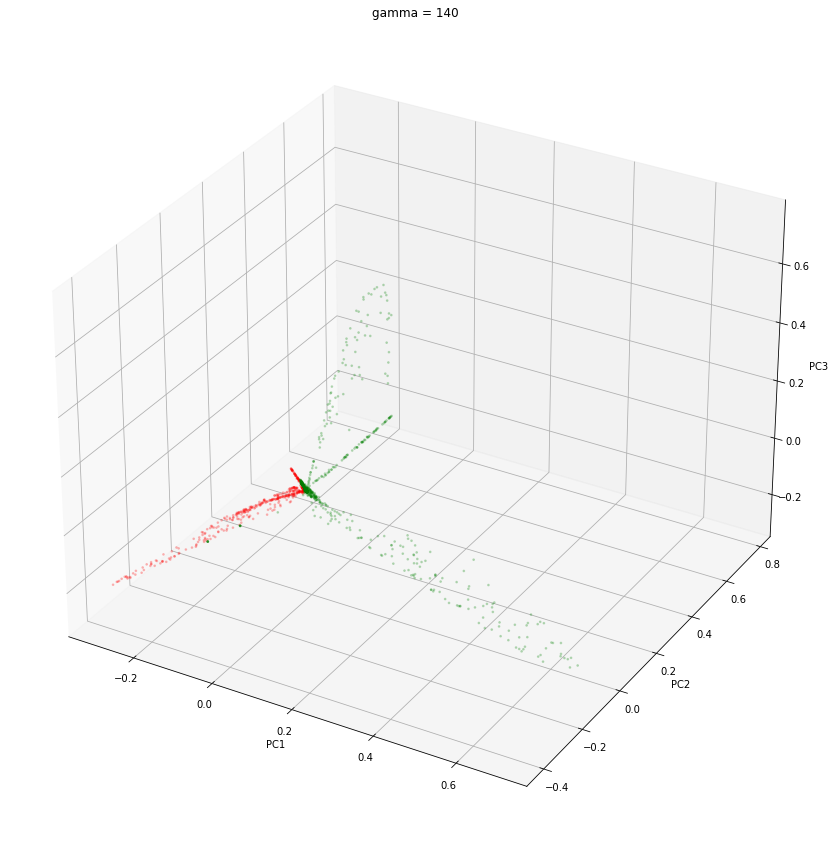

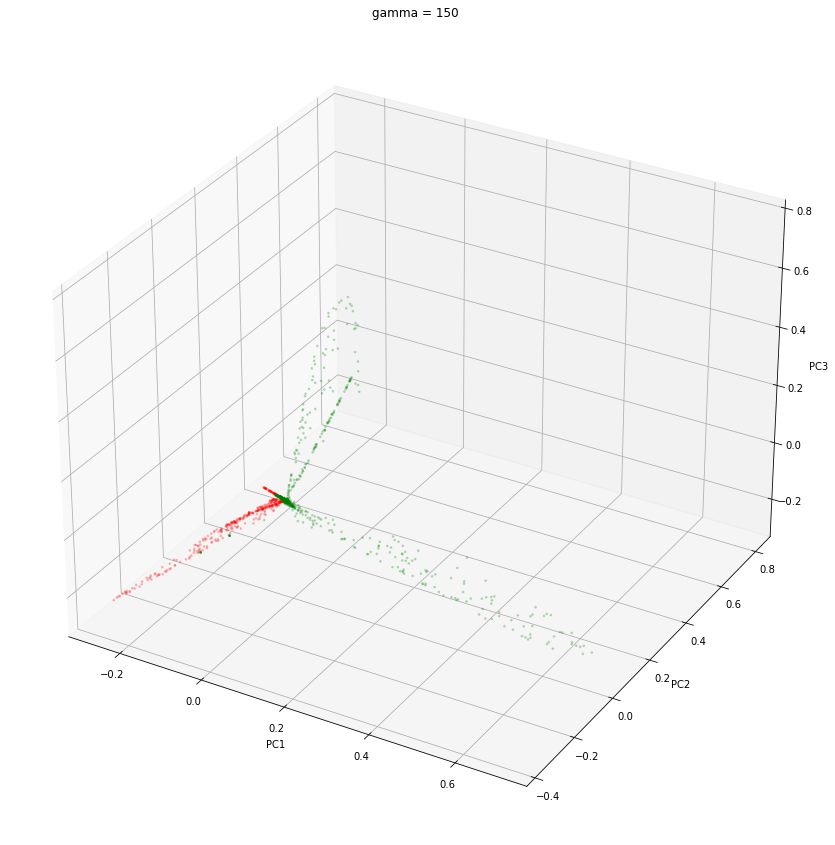

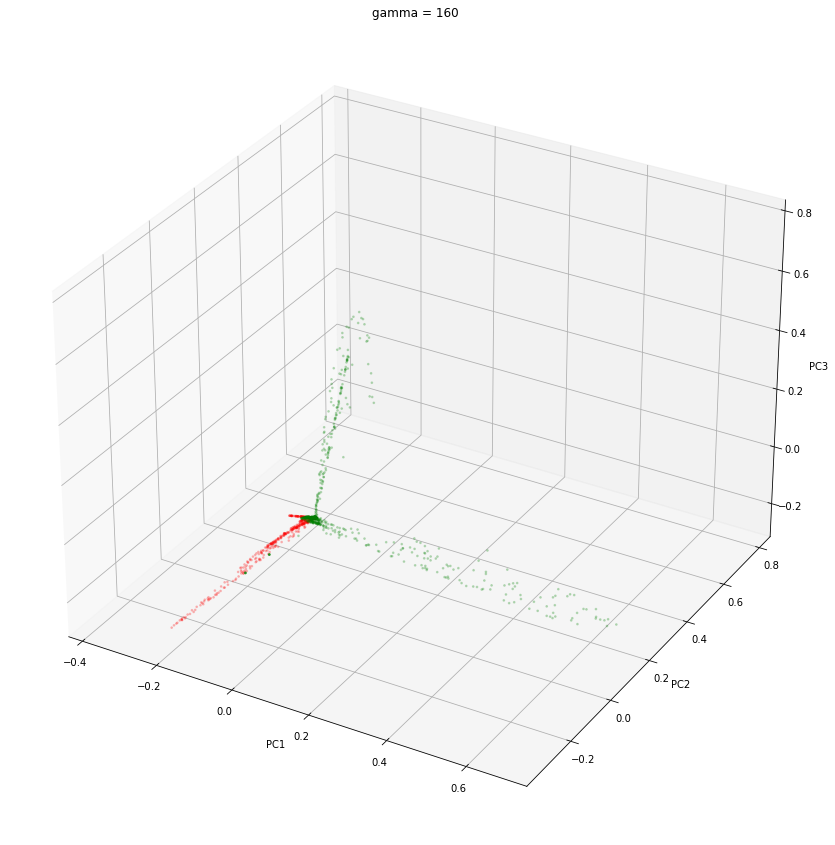

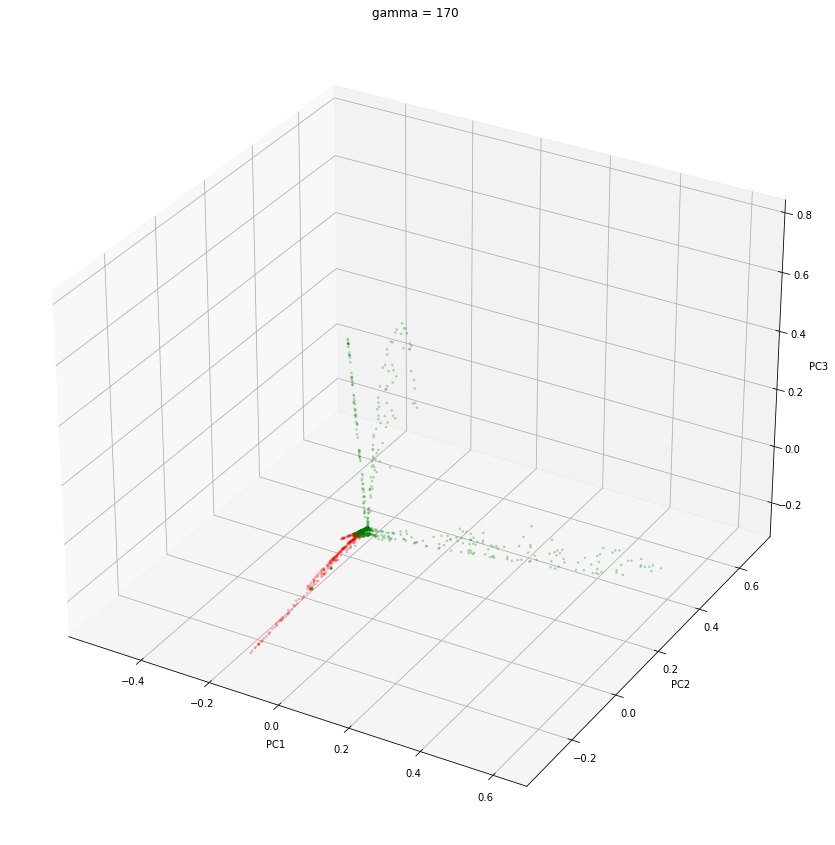

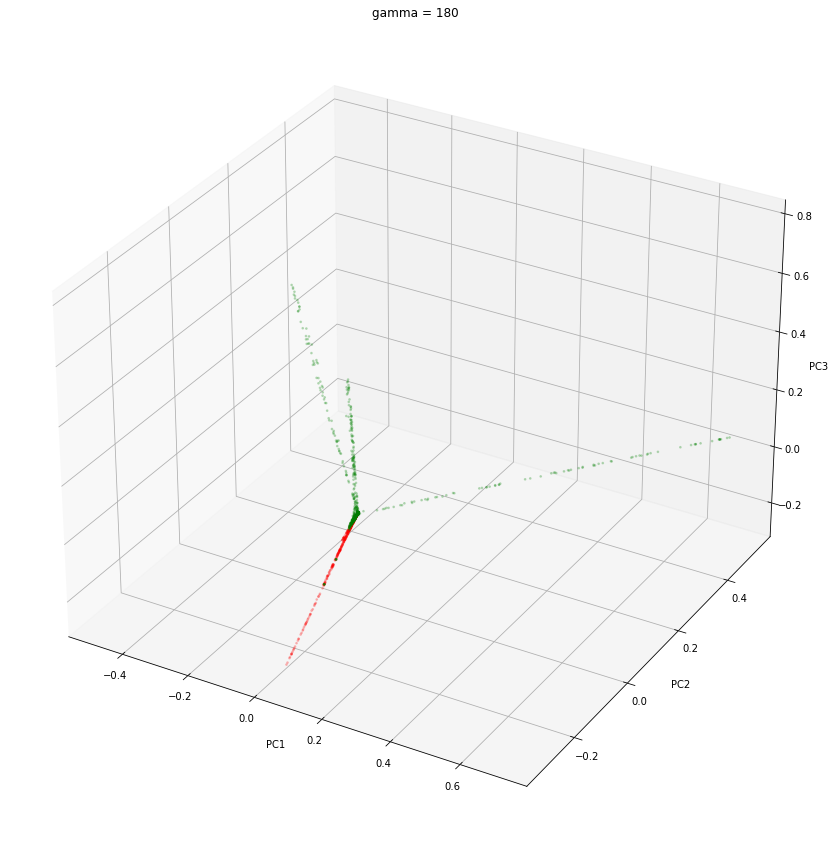

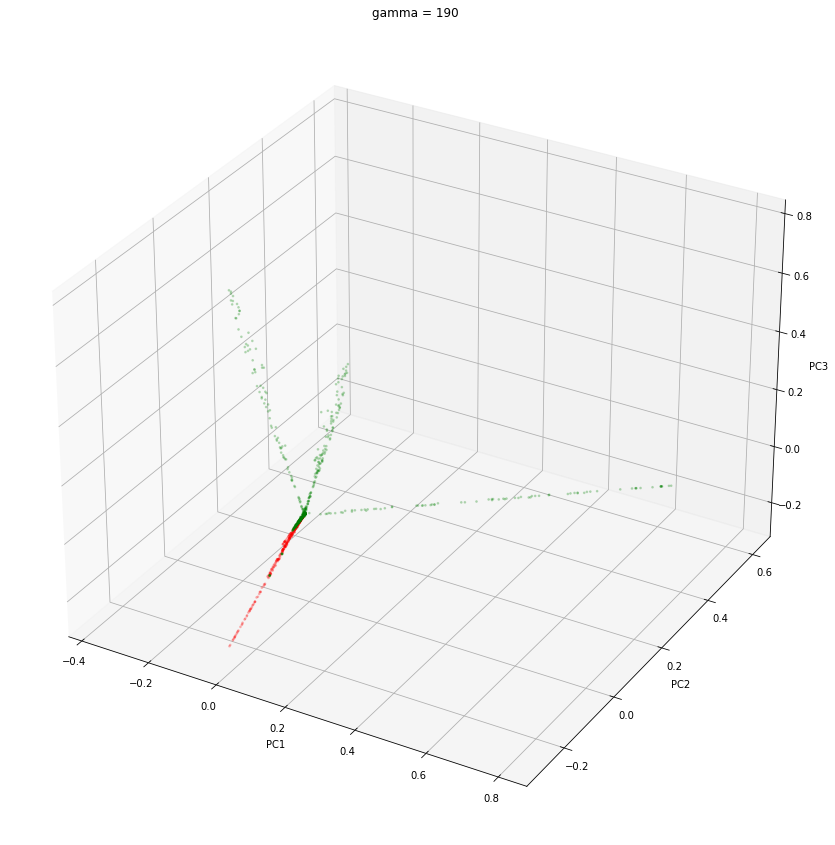

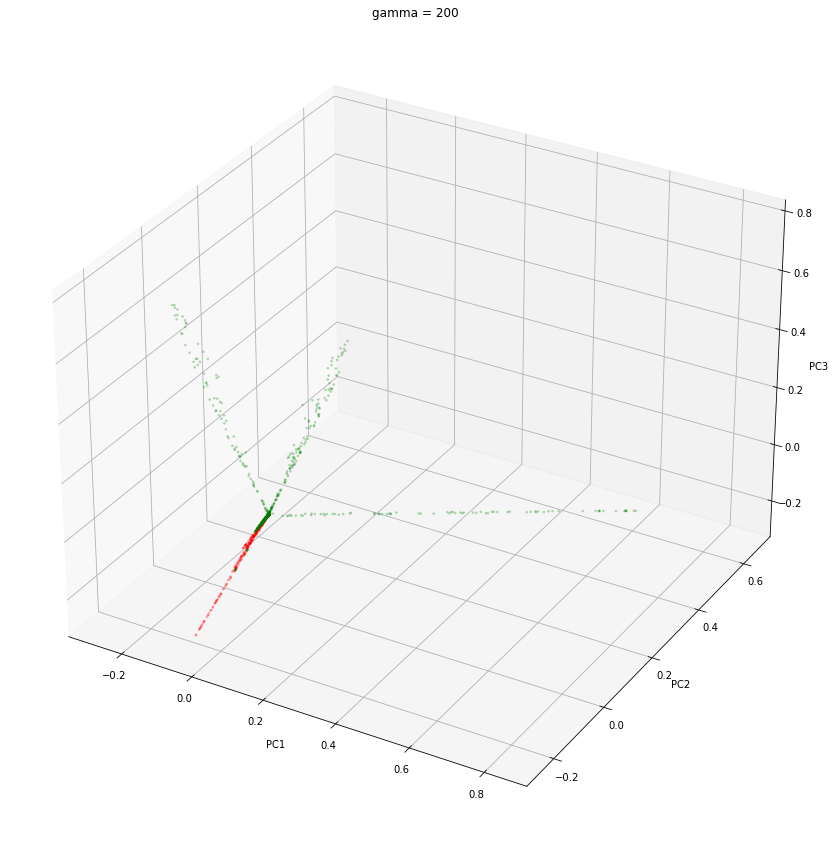

In [12]:
gammas=range(10,201,10)

for gamma in gammas:
    # Kernel PCA: 3 components
    kernel_PCA3 = KernelPCA(kernel="rbf", gamma=gamma, n_components=3)
    data_kPCA3 = pd.DataFrame(kernel_PCA3.fit_transform(data))

    # 3D plot of genuine and forged
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(data_kPCA3[y_test['Class'] == 0][0], data_kPCA3[y_test['Class'] == 0][1], 
               data_kPCA3[y_test['Class'] == 0][2], s=3, color='green', alpha=0.2)
    ax.scatter(data_kPCA3[y_test['Class'] == 1][0], data_kPCA3[y_test['Class'] == 1][1], 
               data_kPCA3[y_test['Class'] == 1][2], s=3, color='red', alpha=0.2)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    ax.set_zlabel('PC3')
    plt.title(f'gamma = {gamma}')
    plt.show()
    
del kernel_PCA3, data_kPCA3

Kernel PCA with 3 components also didn't give great results.

#### 1.3.3. Unsupervised ML methods: T-Distributed Stochastic Neighbor Embedding

Different initialization, metric, early aggregation, perplexity values were manualy checked for TSNE with 2 and 3 components. Below the result allowing to separate genuine and forged banknotes data (with exception of one genuine banknote datapoint being located in forged sector) is presented. 

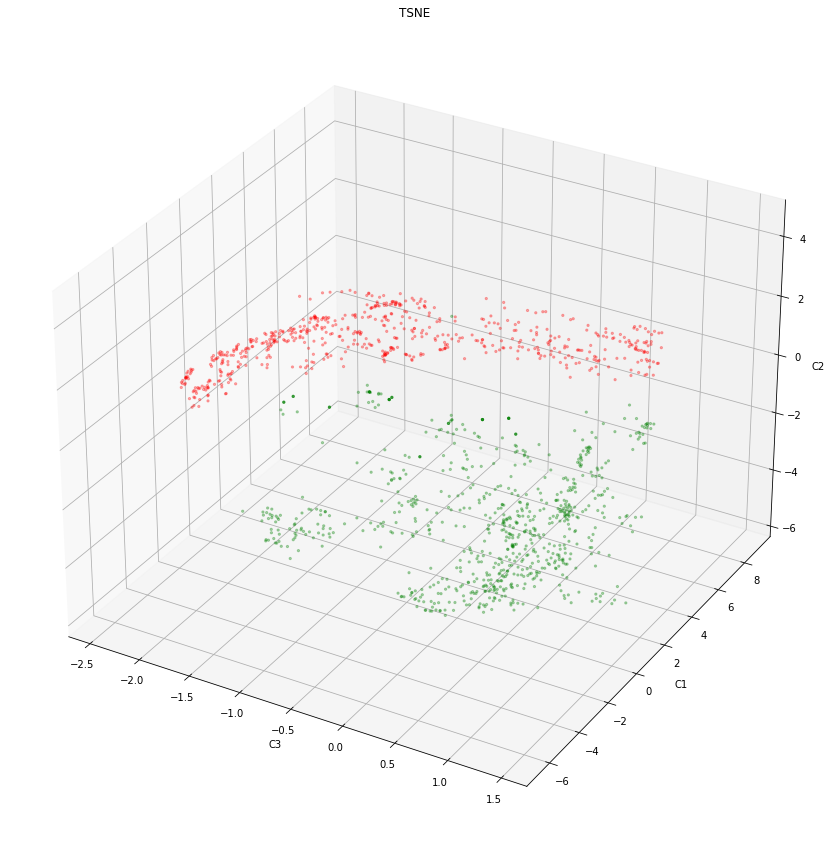

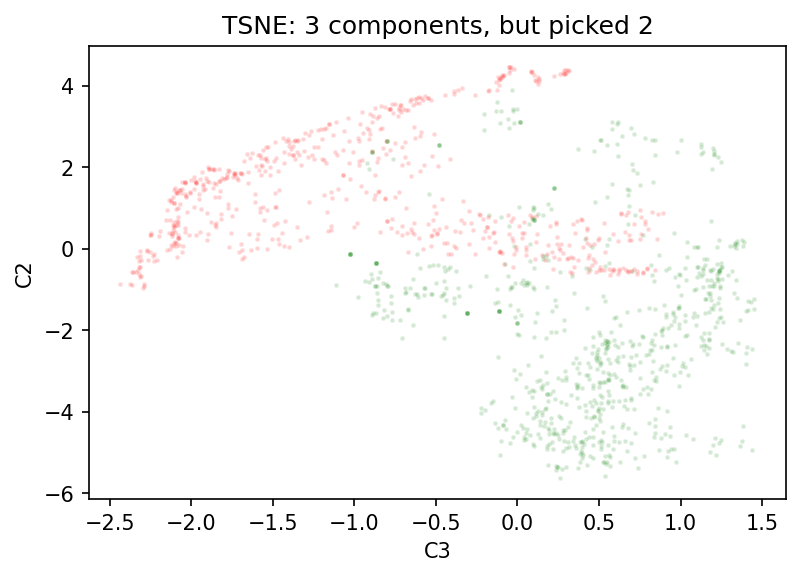

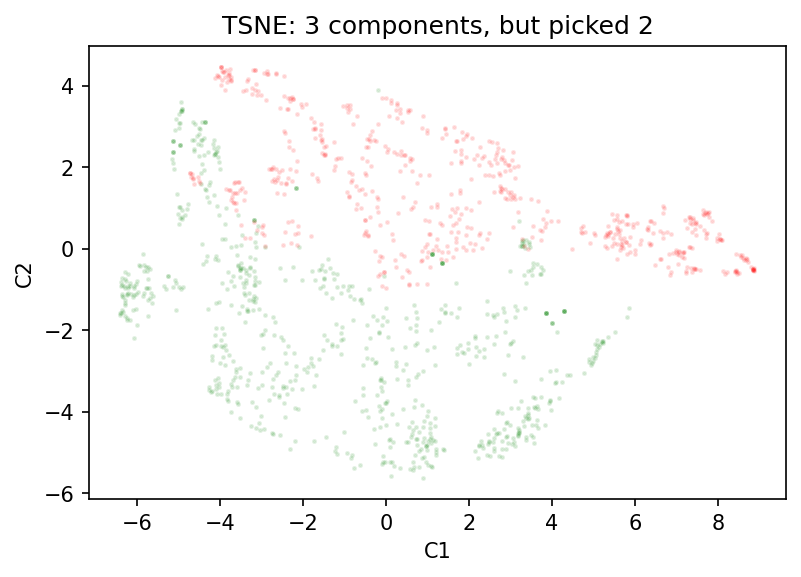

In [13]:
from sklearn.manifold import TSNE

# TSNE: 3 components
data_TSNE = pd.DataFrame(TSNE(n_components=3, init='pca', early_exaggeration=2, perplexity=200, 
                               metric='euclidean').fit_transform(data))

# 3D plot of genuine and forged
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection='3d')
ax.scatter(data_TSNE[y_test['Class'] == 0][2], data_TSNE[y_test['Class'] == 0][0], 
           data_TSNE[y_test['Class'] == 0][1], s=5, color='green', alpha=0.3)
ax.scatter(data_TSNE[y_test['Class'] == 1][2], data_TSNE[y_test['Class'] == 1][0], 
           data_TSNE[y_test['Class'] == 1][1], s=5, color='red', alpha=0.3)
plt.xlabel('C3')
plt.ylabel('C1')
ax.set_zlabel('C2')
plt.title('TSNE')
plt.show()

# 2D plots
plt.figure(dpi=150)
plt.xlabel('C3')
plt.ylabel('C2')
plt.scatter(data_TSNE[y_test['Class'] == 0][2], data_TSNE[y_test['Class'] == 0][1], s=2, color='green', alpha=0.1)
plt.scatter(data_TSNE[y_test['Class'] == 1][2], data_TSNE[y_test['Class'] == 1][1], s=2, color='red', alpha=0.1)
plt.title('TSNE: 3 components, but picked 2')
plt.show()

plt.figure(dpi=150)
plt.xlabel('C1')
plt.ylabel('C2')
plt.scatter(data_TSNE[y_test['Class'] == 0][0], data_TSNE[y_test['Class'] == 0][1], s=2, color='green', alpha=0.1)
plt.scatter(data_TSNE[y_test['Class'] == 1][0], data_TSNE[y_test['Class'] == 1][1], s=2, color='red', alpha=0.1)
plt.title('TSNE: 3 components, but picked 2')
plt.show()

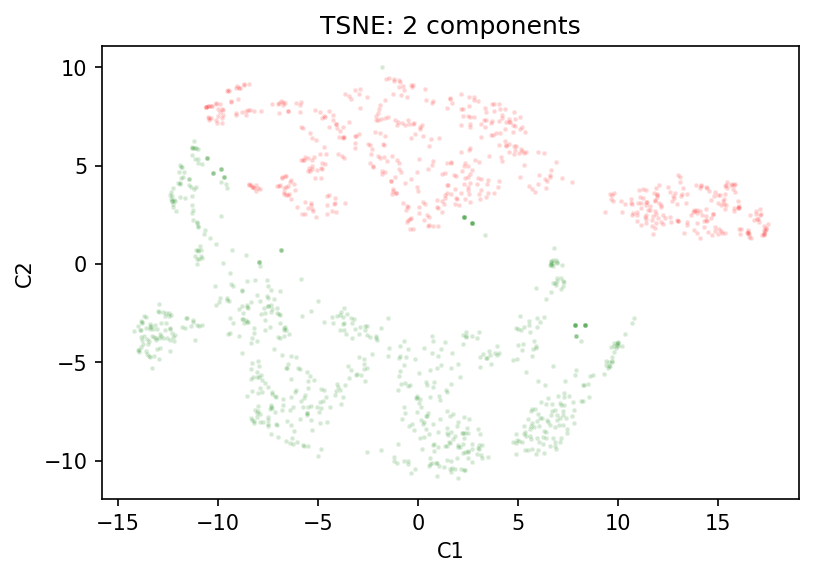

In [14]:
# TSNE: 2 components
data_TSNE2 = pd.DataFrame(TSNE(n_components=2, init='pca', early_exaggeration=8, perplexity=160, 
                               metric='euclidean').fit_transform(data))

# 2D plot of genuine and forged
plt.figure(dpi=150)
plt.xlabel('C1')
plt.ylabel('C2')
plt.scatter(data_TSNE2[y_test['Class'] == 0][0], data_TSNE2[y_test['Class'] == 0][1], s=2, color='green', alpha=0.1)
plt.scatter(data_TSNE2[y_test['Class'] == 1][0], data_TSNE2[y_test['Class'] == 1][1], s=2, color='red', alpha=0.1)
plt.title('TSNE: 2 components')
plt.show()


The set of components obtained with 3-components TSNE would be very useful as variables for supervised ML algoritms, however many SML models were proven not to need UML based dimensionality reduction performed on this dataset - excelent results can be obtained with just dropping V4 (https://github.com/BeataWereszczynska/SML_forged_banknotes). But there is still a question to be answered: would UML clustering algorithms perform better on data_MAN or data_TSNE?

## 2. Clustering models

### 2.1. K-means

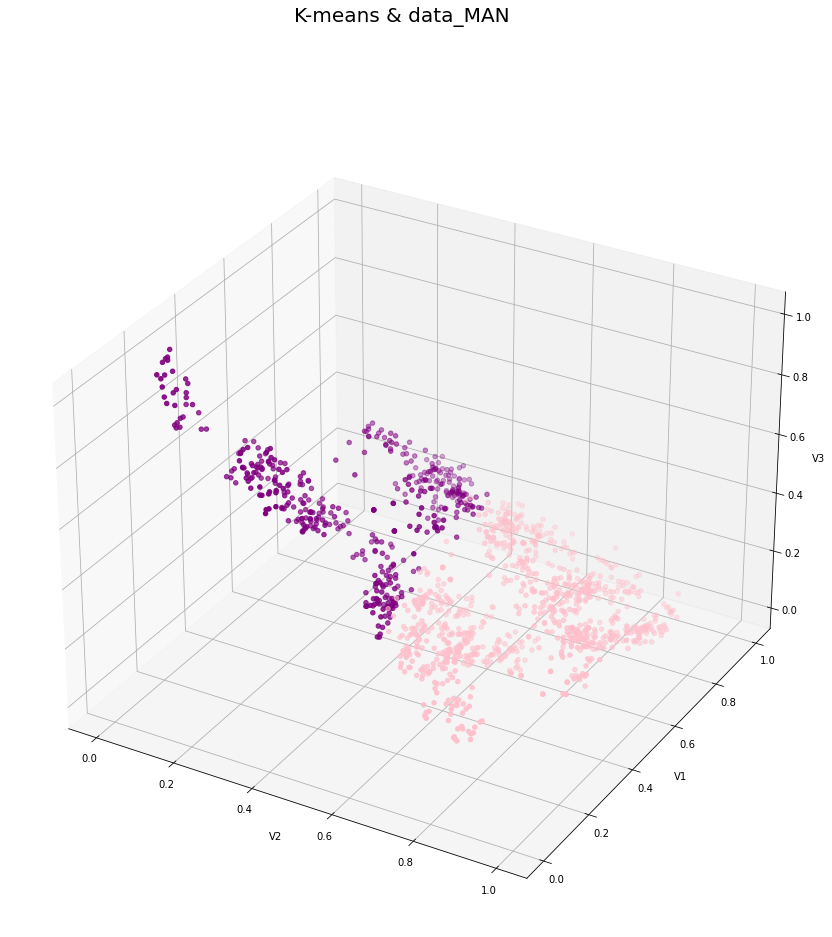

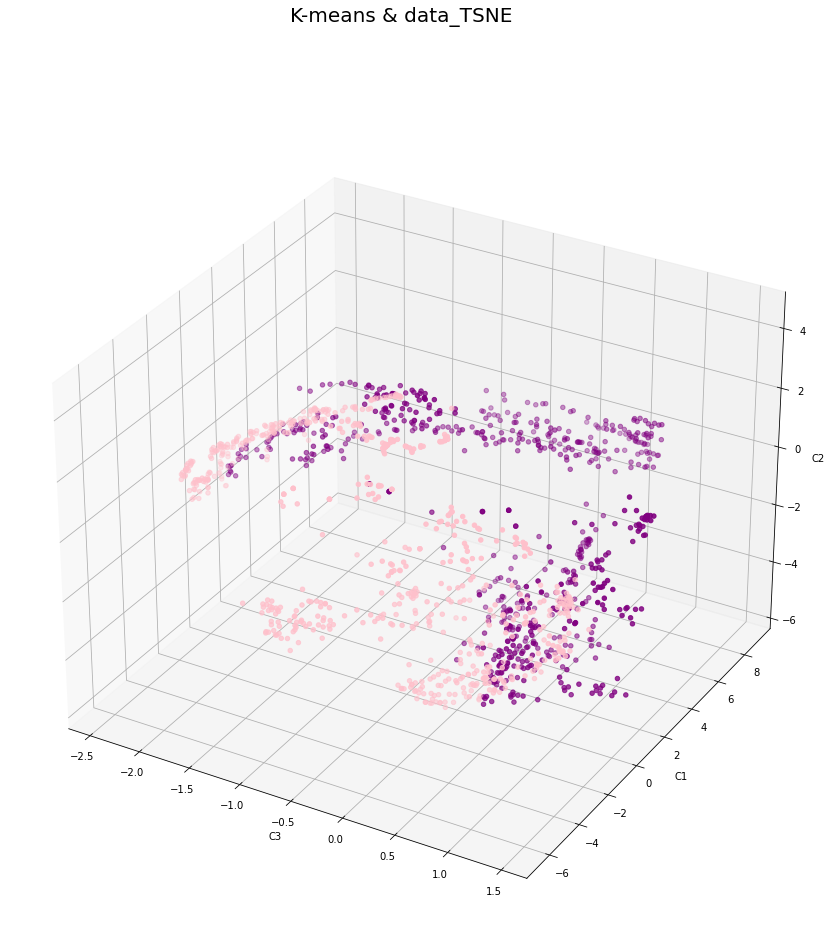

In [15]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from sklearn.cluster import KMeans

km = KMeans(n_clusters=2,n_init=100)

# K-means on data_MAN
km.fit(data_MAN)

color = ['pink', 'purple']
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection='3d')
for label in np.unique(km.labels_):
    data_MAN_ = data_MAN[label == km.labels_]
    ax.scatter(data_MAN_['V2'], data_MAN_['V1'], data_MAN_['V3'], color = color[label])
plt.xlabel('V2')
plt.ylabel('V1')
ax.set_zlabel('V3')
fig.suptitle('K-means & data_MAN', fontsize=20)
plt.show()

# K-means on data_TSNE
km.fit(data_TSNE)

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection='3d')
for label in np.unique(km.labels_):
    data_TSNE_ = data_TSNE[label == km.labels_]
    ax.scatter(data_TSNE_[2], data_TSNE_[0], data_TSNE_[1], color = color[label])
plt.xlabel('C3')
plt.ylabel('C1')
ax.set_zlabel('C2')
fig.suptitle('K-means & data_TSNE', fontsize=20)
plt.show()

The results of using K-means are far below expectations in both cases.

### 2.2. Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

DBSCAN is not the best for this task, as it does not accept number of clusters as a parameter. But one can try tu use it anyway to try to get 2 clusters just for the sake of exercise, like on the example below.

DBSCAN found 2 clusters and 357 points of noise in data_MAN.


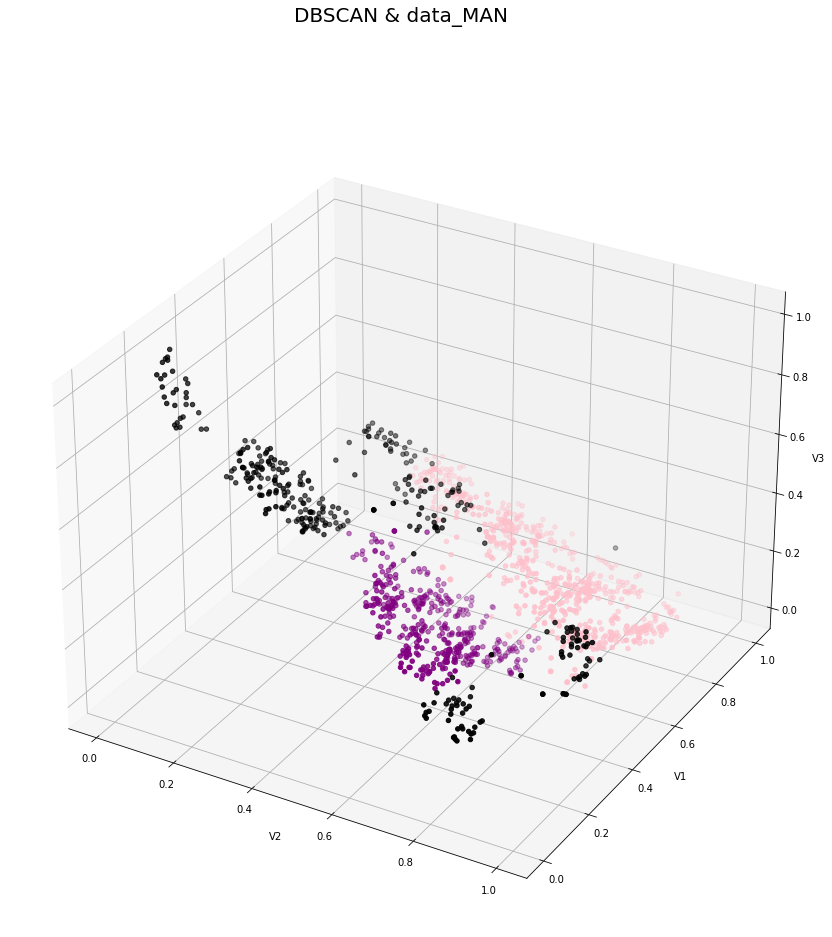

In [16]:
from sklearn.cluster import DBSCAN

# DBSCAN & data_MAN
dbscan = DBSCAN(eps=0.135, min_samples=95)
dbscan.fit(data_MAN)
print(f'DBSCAN found {len(set(dbscan.labels_) - set([-1]))} clusters and {(dbscan.labels_ == -1).sum()} points of noise in data_MAN.')

color = ['pink', 'purple', 'black']
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection='3d')
for label in np.unique(dbscan.labels_):
    data_MAN_ = data_MAN[label == dbscan.labels_]
    ax.scatter(data_MAN_['V2'], data_MAN_['V1'], data_MAN_['V3'], color = color[label])
plt.xlabel('V2')
plt.ylabel('V1')
ax.set_zlabel('V3')
fig.suptitle('DBSCAN & data_MAN', fontsize=20)
plt.show()

DBSCAN found 2 clusters and 112 points of noise in data_TSNE.


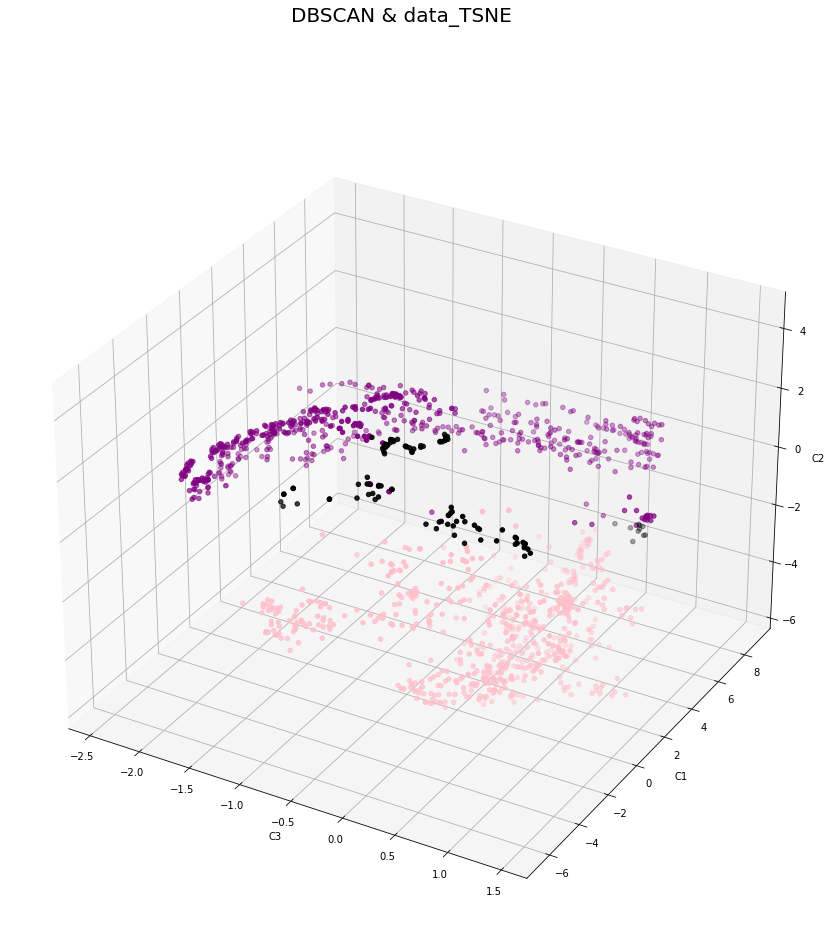

In [17]:
# DBSCAN & data_TSNE
dbscan = DBSCAN(eps=2, min_samples=114)
dbscan.fit(data_TSNE)
print(f'DBSCAN found {len(set(dbscan.labels_) - set([-1]))} clusters and {(dbscan.labels_ == -1).sum()} points of noise in data_TSNE.')

color = ['pink', 'purple', 'black']
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection='3d')
for label in np.unique(dbscan.labels_):
    data_TSNE_ = data_TSNE[label == dbscan.labels_]
    ax.scatter(data_TSNE_[2], data_TSNE_[0], data_TSNE_[1], color = color[label])
plt.xlabel('C3')
plt.ylabel('C1')
ax.set_zlabel('C2')
fig.suptitle('DBSCAN & data_TSNE', fontsize=20)
plt.show()

### 2.3. Agglomerative clustering

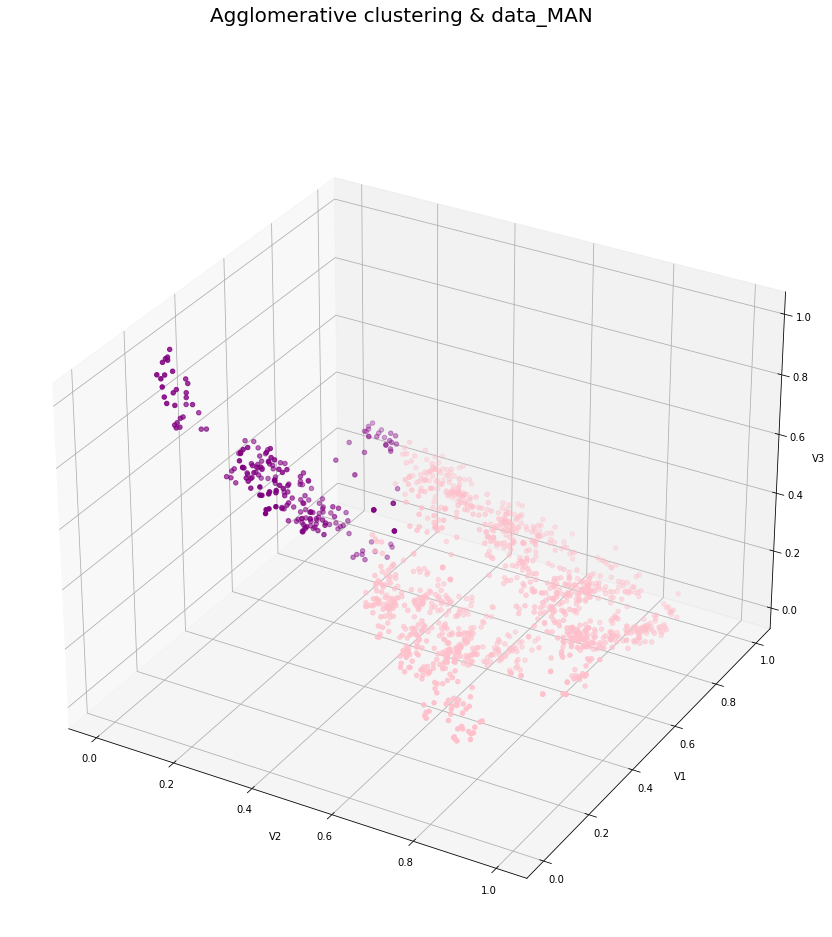

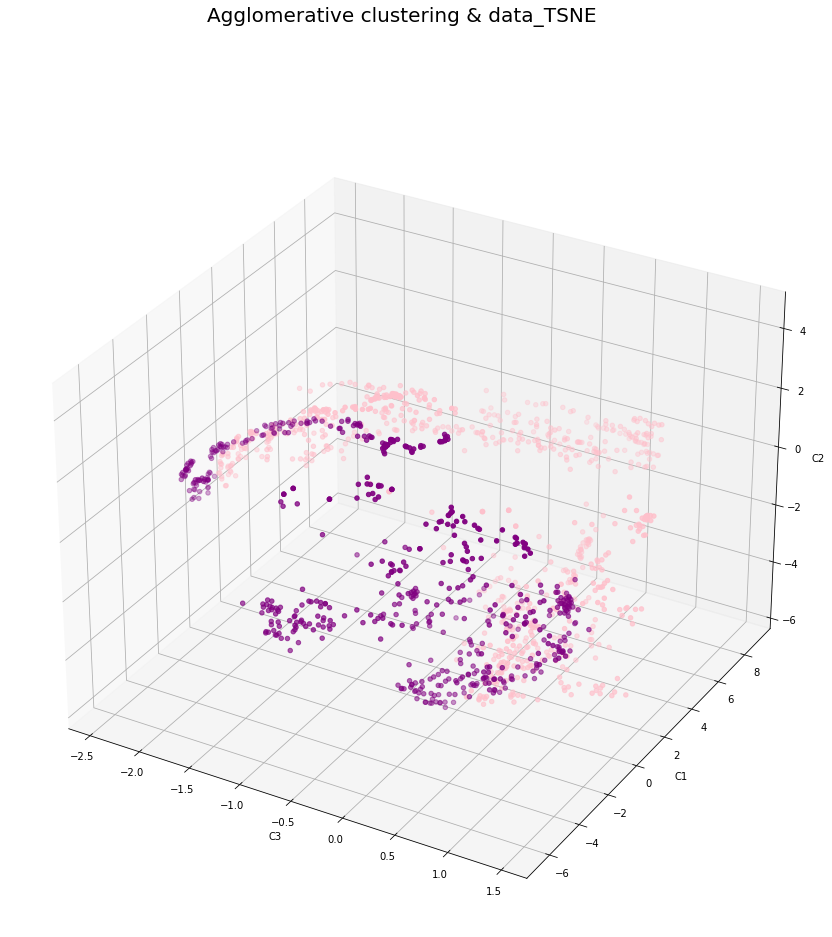

In [18]:
from sklearn.cluster import AgglomerativeClustering
ag = AgglomerativeClustering(n_clusters=2, linkage='ward')

# Agglomerative clustering & data_MAN
ag = ag.fit(data_MAN)

color = ['pink', 'purple']
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection='3d')
for label in np.unique(ag.labels_):
    data_MAN_ = data_MAN[label == ag.labels_]
    ax.scatter(data_MAN_['V2'], data_MAN_['V1'], data_MAN_['V3'], color = color[label])
plt.xlabel('V2')
plt.ylabel('V1')
ax.set_zlabel('V3')
fig.suptitle('Agglomerative clustering & data_MAN', fontsize=20)
plt.show()

# Agglomerative clustering & data_TSNE
ag.fit(data_TSNE)

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection='3d')
for label in np.unique(ag.labels_):
    data_TSNE_ = data_TSNE[label == ag.labels_]
    ax.scatter(data_TSNE_[2], data_TSNE_[0], data_TSNE_[1], color = color[label])
plt.xlabel('C3')
plt.ylabel('C1')
ax.set_zlabel('C2')
fig.suptitle('Agglomerative clustering & data_TSNE', fontsize=20)
plt.show()